In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('heart_cleaned.csv')
df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289.0,0,172,0,0.0,False,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49,0,160,180.0,0,156,0,1.0,True,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37,1,130,283.0,0,98,0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48,0,138,214.0,0,108,1,1.5,True,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54,1,150,195.0,0,122,0,0.0,False,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [4]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())

            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                else:
                    self.continuous_features.append(col)
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        return self.continuous_features, self.binary_features
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()


In [5]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutual information media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutual information
    """
    # Calcolo mutual information per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [6]:
def add_progressive_noise(df: pd.DataFrame, target_column: str) -> dict:
    """
    Aggiunge progressivamente rumore a una colonna target binaria (0/1) di un DataFrame.

    La funzione itera dal 0% al 100% con incrementi del 10%, e per ogni step
    inverte una percentuale corrispondente di etichette nella colonna target.

    Args:
        df (pd.DataFrame): Il DataFrame di input.
        target_column (str): Il nome della colonna target binaria da modificare.

    Returns:
        dict: Un dizionario di DataFrame. Le chiavi indicano la percentuale
              di rumore e i valori sono i DataFrame modificati.
    """
    # Controlla che la colonna target sia binaria (contenente solo 0 e 1)
    if not all(df[target_column].isin([0, 1])):
        raise ValueError(f"La colonna '{target_column}' non è binaria (deve contenere solo 0 e 1).")

    noisy_datasets = {}
    n_samples = len(df)
    
    print(f"DataFrame originale con {n_samples} righe.")

    # Itera attraverso le percentuali di rumore da 0 a 100 con step di 10
    for percentage in range(0, 101, 10):
        # Lavoriamo sempre su una copia pulita del df originale per evitare rumore cumulativo
        df_noisy = df.copy()
        
        # Se la percentuale è 0, non facciamo nulla e salviamo la copia originale
        if percentage == 0:
            noisy_datasets[f'0%_noise'] = df_noisy
            continue

        # Calcola il numero di etichette da "flippare" (invertire)
        n_to_flip = int(np.floor(n_samples * (percentage / 100)))

        # Seleziona casualmente gli indici delle righe da modificare
        # Usiamo random_state per la riproducibilità degli esperimenti
        indices_to_flip = df.sample(n=n_to_flip, random_state=42).index

        # Inverti i valori nella colonna target per gli indici selezionati
        # Questo trucco (1 - valore) funziona perfettamente per etichette binarie 0/1
        df_noisy.loc[indices_to_flip, target_column] = ~df_noisy.loc[indices_to_flip, target_column]

        
        # Salva il DataFrame rumoroso nel dizionario
        key_name = f'{percentage}%_noise'
        noisy_datasets[key_name] = df_noisy
        print(f"Generato dataset con {percentage}% di rumore ({n_to_flip} etichette invertite).")

    return noisy_datasets


In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

all_metrics_noisy = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_noisy= {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}

DataFrame originale con 918 righe.
Generato dataset con 10% di rumore (91 etichette invertite).
Generato dataset con 20% di rumore (183 etichette invertite).
Generato dataset con 30% di rumore (275 etichette invertite).
Generato dataset con 40% di rumore (367 etichette invertite).
Generato dataset con 50% di rumore (459 etichette invertite).
Generato dataset con 60% di rumore (550 etichette invertite).
Generato dataset con 70% di rumore (642 etichette invertite).
Generato dataset con 80% di rumore (734 etichette invertite).
Generato dataset con 90% di rumore (826 etichette invertite).
Generato dataset con 100% di rumore (918 etichette invertite).


--- INIZIO TRAINING: DECISION TREE ---
DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training Decision Tree (Naive) at Step 0 (Noise: 0%) =====
Misure di performance globali decision tree naive

Accuracy: 0.7608695652173914
Precision: 0.8461538461538461
Recall: 0.719626168224299
F1-

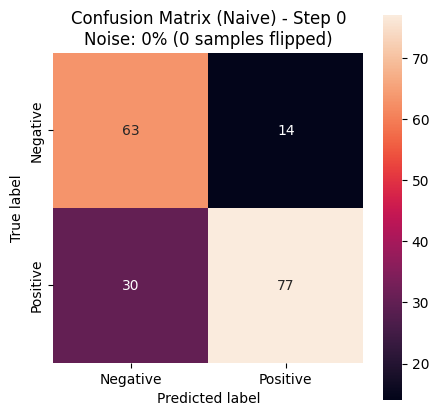

Feature Importances: [0.04499541 0.02981416 0.06100574 0.07224769 0.01373097 0.1181934
 0.01236147 0.10924043 0.07745198 0.         0.00366451 0.00710693
 0.00687096 0.01240593 0.00543582 0.         0.00274838 0.42272619]
✅ Step 0 completed (Noise: 0%)


===== Training Decision Tree (Naive) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.7065217391304348
Precision: 0.7476635514018691
Recall: 0.7476635514018691
F1-score: 0.7476635514018691
Step 1 - Decision Tree (Naive) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.7065
  Accuracy Train:  1.0000
  Precision:       0.7477
  Recall:          0.7477
  F1-score:        0.7477
  Training time:   0.0027 sec


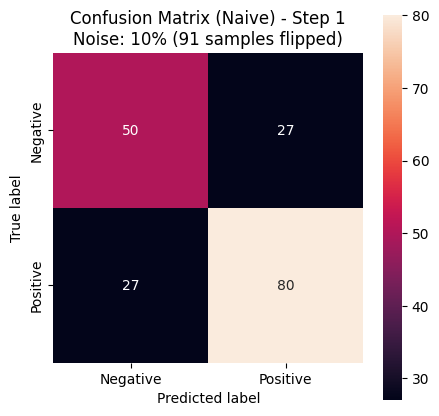

Feature Importances: [0.10501917 0.03294814 0.0999997  0.11119344 0.0036389  0.10479279
 0.04122053 0.08244856 0.04248994 0.01119511 0.00827767 0.01257946
 0.01711    0.01147142 0.02103043 0.00975266 0.         0.28483207]
✅ Step 1 completed (Noise: 10%)


===== Training Decision Tree (Naive) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.6793478260869565
Precision: 0.7553191489361702
Recall: 0.6635514018691588
F1-score: 0.7064676616915423
Step 2 - Decision Tree (Naive) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.6793
  Accuracy Train:  1.0000
  Precision:       0.7553
  Recall:          0.6636
  F1-score:        0.7065
  Training time:   0.0025 sec


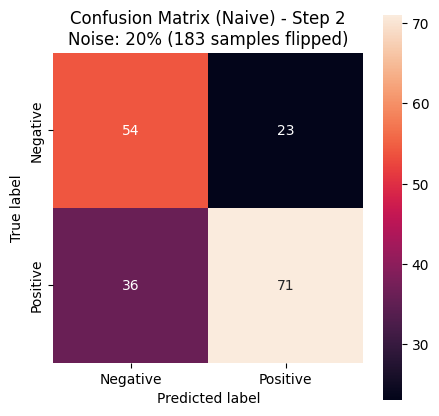

Feature Importances: [0.12217996 0.0312871  0.11169218 0.1473342  0.01556473 0.15924935
 0.04446159 0.11646979 0.02192904 0.01078077 0.01233851 0.
 0.00573137 0.01120269 0.00942726 0.00364087 0.         0.17671056]
✅ Step 2 completed (Noise: 20%)


===== Training Decision Tree (Naive) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.6141304347826086
Precision: 0.7142857142857143
Recall: 0.5607476635514018
F1-score: 0.6282722513089005
Step 3 - Decision Tree (Naive) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.6141
  Accuracy Train:  1.0000
  Precision:       0.7143
  Recall:          0.5607
  F1-score:        0.6283
  Training time:   0.0025 sec


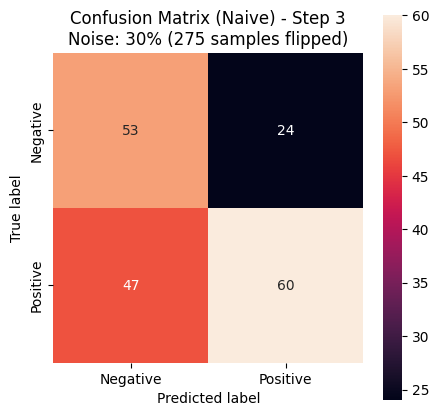

Feature Importances: [0.14758928 0.02323448 0.13578269 0.20523241 0.0232569  0.1547055
 0.01062518 0.11314175 0.02091505 0.00708705 0.00523524 0.
 0.01195558 0.01953481 0.01537207 0.         0.01823545 0.08809657]
✅ Step 3 completed (Noise: 30%)


===== Training Decision Tree (Naive) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.5597826086956522
Precision: 0.6625
Recall: 0.4953271028037383
F1-score: 0.5668449197860963
Step 4 - Decision Tree (Naive) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.5598
  Accuracy Train:  1.0000
  Precision:       0.6625
  Recall:          0.4953
  F1-score:        0.5668
  Training time:   0.0028 sec


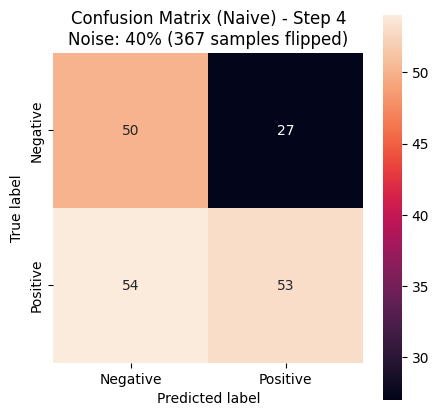

Feature Importances: [0.13227571 0.02797313 0.10850568 0.24769164 0.02600069 0.18428428
 0.01275818 0.10795805 0.0162472  0.01461184 0.02460328 0.01016785
 0.00814732 0.02445242 0.02269517 0.         0.02757158 0.00405597]
✅ Step 4 completed (Noise: 40%)


===== Training Decision Tree (Naive) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.5543478260869565
Precision: 0.6373626373626373
Recall: 0.5420560747663551
F1-score: 0.5858585858585859
Step 5 - Decision Tree (Naive) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.5543
  Accuracy Train:  1.0000
  Precision:       0.6374
  Recall:          0.5421
  F1-score:        0.5859
  Training time:   0.0035 sec


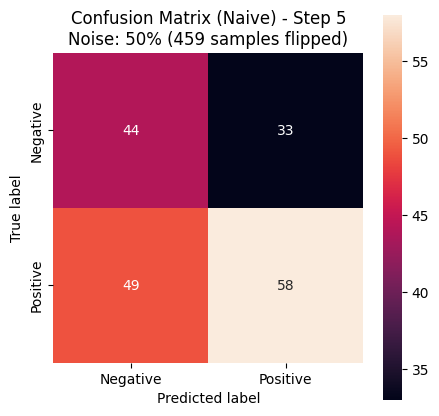

Feature Importances: [0.15062615 0.00728565 0.11600042 0.20266701 0.02246574 0.17424477
 0.01449324 0.12292437 0.02982478 0.02238398 0.00810962 0.00682615
 0.03113475 0.01286698 0.01742119 0.02064094 0.00922803 0.03085623]
✅ Step 5 completed (Noise: 50%)


===== Training Decision Tree (Naive) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.3858695652173913
Precision: 0.4625
Recall: 0.34579439252336447
F1-score: 0.39572192513368987
Step 6 - Decision Tree (Naive) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.3859
  Accuracy Train:  1.0000
  Precision:       0.4625
  Recall:          0.3458
  F1-score:        0.3957
  Training time:   0.0035 sec


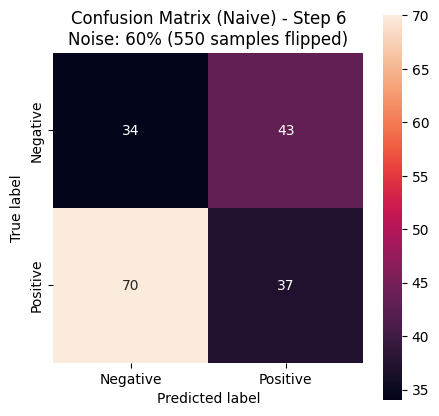

Feature Importances: [0.22460117 0.01484403 0.11519096 0.24240744 0.01674852 0.16438462
 0.01009939 0.08908176 0.00458072 0.02543042 0.01663429 0.
 0.00806446 0.02539008 0.00542844 0.00682892 0.00791449 0.02237027]
✅ Step 6 completed (Noise: 60%)


===== Training Decision Tree (Naive) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.4076086956521739
Precision: 0.4875
Recall: 0.3644859813084112
F1-score: 0.41711229946524064
Step 7 - Decision Tree (Naive) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.4076
  Accuracy Train:  1.0000
  Precision:       0.4875
  Recall:          0.3645
  F1-score:        0.4171
  Training time:   0.0025 sec


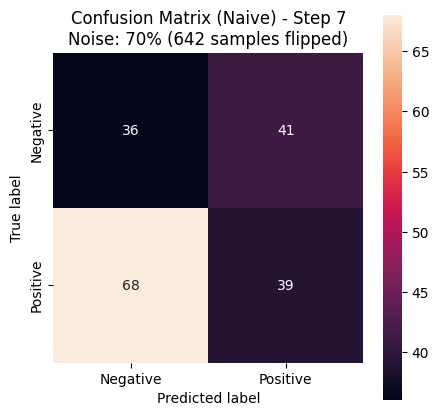

Feature Importances: [0.13075225 0.02136464 0.13245054 0.16747675 0.01315352 0.19004468
 0.01893771 0.10485138 0.03074834 0.02300442 0.0088652  0.
 0.02483366 0.01728178 0.03327354 0.00786077 0.         0.07510083]
✅ Step 7 completed (Noise: 70%)


===== Training Decision Tree (Naive) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.33695652173913043
Precision: 0.40963855421686746
Recall: 0.3177570093457944
F1-score: 0.35789473684210527
Step 8 - Decision Tree (Naive) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.3370
  Accuracy Train:  1.0000
  Precision:       0.4096
  Recall:          0.3178
  F1-score:        0.3579
  Training time:   0.0025 sec


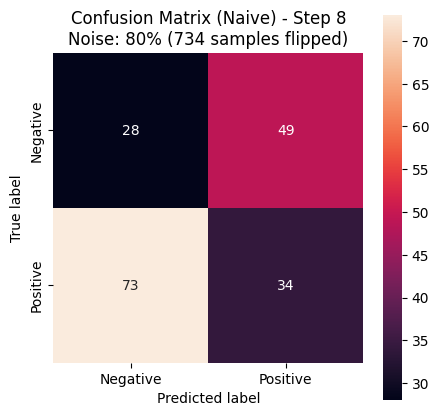

Feature Importances: [0.12867332 0.02742088 0.12129953 0.14964783 0.02084509 0.15315553
 0.01895263 0.1181782  0.04721821 0.02317575 0.         0.00935706
 0.01543104 0.         0.01236455 0.00412916 0.00458796 0.14556326]
✅ Step 8 completed (Noise: 80%)


===== Training Decision Tree (Naive) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.2391304347826087
Precision: 0.2537313432835821
Recall: 0.1588785046728972
F1-score: 0.19540229885057472
Step 9 - Decision Tree (Naive) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.2391
  Accuracy Train:  1.0000
  Precision:       0.2537
  Recall:          0.1589
  F1-score:        0.1954
  Training time:   0.0025 sec


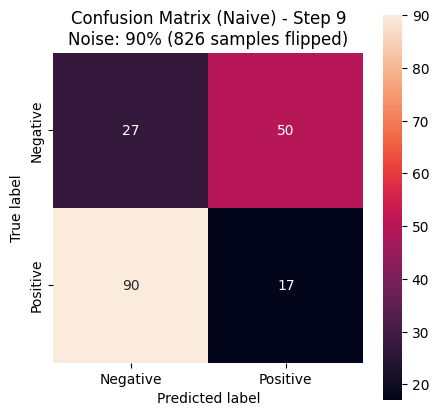

Feature Importances: [0.09259137 0.03150557 0.10278472 0.09427607 0.02463824 0.15363424
 0.02718756 0.1008247  0.06972091 0.01787321 0.         0.00087055
 0.00431474 0.00561068 0.00714342 0.00091397 0.         0.26611005]
✅ Step 9 completed (Noise: 90%)


===== Training Decision Tree (Naive) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali decision tree naive

Accuracy: 0.2554347826086957
Precision: 0.3404255319148936
Recall: 0.29906542056074764
F1-score: 0.31840796019900497
Step 10 - Decision Tree (Naive) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.2554
  Accuracy Train:  1.0000
  Precision:       0.3404
  Recall:          0.2991
  F1-score:        0.3184
  Training time:   0.0021 sec


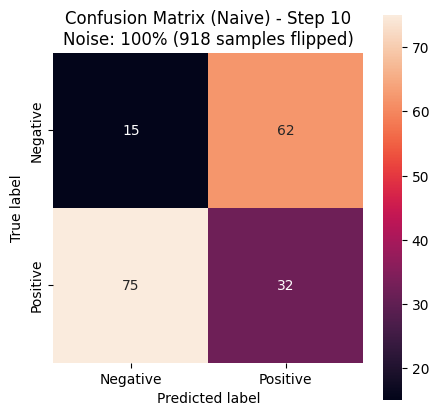

Feature Importances: [0.0611079  0.02719666 0.05237669 0.06481616 0.01503973 0.10676164
 0.01236147 0.11679872 0.07745198 0.00458064 0.00366451 0.00710693
 0.         0.01707819 0.01093259 0.         0.         0.42272619]
✅ Step 10 completed (Noise: 100%)

DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training Decision Tree (Optimized) at Step 0 (Noise: 0%) =====
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 0 - Decision Tree (Optimized) - Noise: 0%
  Samples flipped: 0
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.7989
  Accuracy Train:  0.8651
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0009 sec


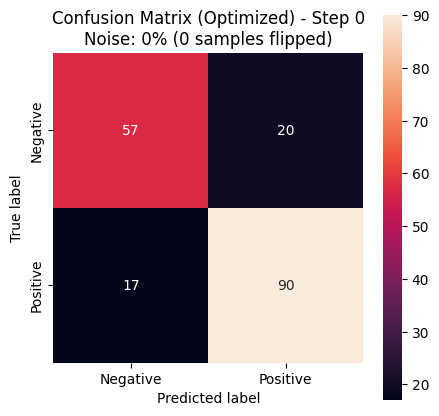

Feature Importances: [0.00771895 0.05674302 0.         0.         0.         0.
 0.04197239 0.         0.15538234 0.         0.         0.
 0.         0.         0.         0.         0.         0.7381833 ]
✅ Step 0 completed (Noise: 0%)


===== Training Decision Tree (Optimized) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036
Step 1 - Decision Tree (Optimized) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.7989
  Accuracy Train:  0.7956
  Precision:       0.8182
  Recall:          0.8411
  F1-score:        0.8295
  Training time:   0.0008 sec


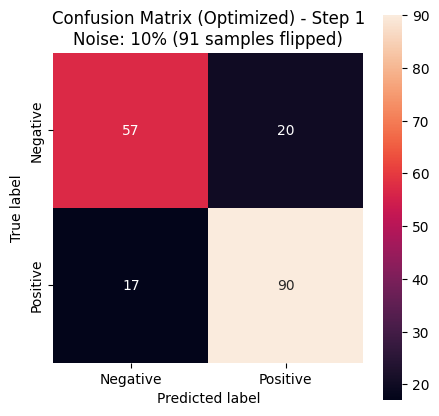

Feature Importances: [0.         0.03802095 0.         0.         0.0336615  0.
 0.07352106 0.         0.0961729  0.         0.         0.
 0.         0.         0.         0.         0.         0.75862359]
✅ Step 1 completed (Noise: 10%)


===== Training Decision Tree (Optimized) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.8043478260869565
Precision: 0.8317757009345794
Recall: 0.8317757009345794
F1-score: 0.8317757009345794
Step 2 - Decision Tree (Optimized) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.8043
  Accuracy Train:  0.7398
  Precision:       0.8318
  Recall:          0.8318
  F1-score:        0.8318
  Training time:   0.0008 sec


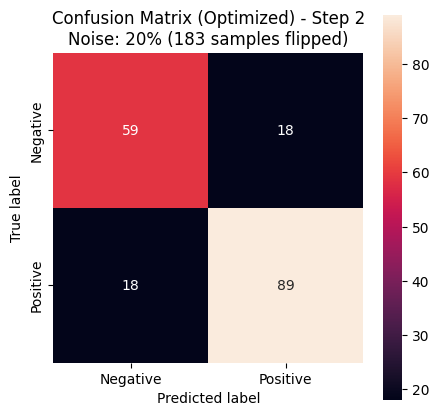

Feature Importances: [0.         0.11292441 0.         0.         0.01454998 0.
 0.17540127 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.69712433]
✅ Step 2 completed (Noise: 20%)


===== Training Decision Tree (Optimized) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.8043478260869565
Precision: 0.808695652173913
Recall: 0.8691588785046729
F1-score: 0.8378378378378378
Step 3 - Decision Tree (Optimized) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.8043
  Accuracy Train:  0.6635
  Precision:       0.8087
  Recall:          0.8692
  F1-score:        0.8378
  Training time:   0.0008 sec


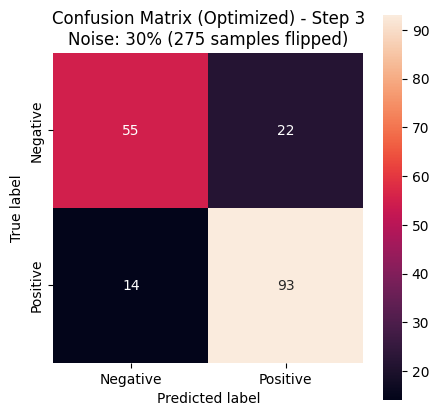

Feature Importances: [0.         0.09841942 0.         0.         0.         0.
 0.06696041 0.03663275 0.08100098 0.         0.         0.
 0.01231738 0.         0.         0.0571916  0.         0.64747745]
✅ Step 3 completed (Noise: 30%)


===== Training Decision Tree (Optimized) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.7065217391304348
Precision: 0.8533333333333334
Recall: 0.5981308411214953
F1-score: 0.7032967032967034
Step 4 - Decision Tree (Optimized) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.7065
  Accuracy Train:  0.6063
  Precision:       0.8533
  Recall:          0.5981
  F1-score:        0.7033
  Training time:   0.0008 sec


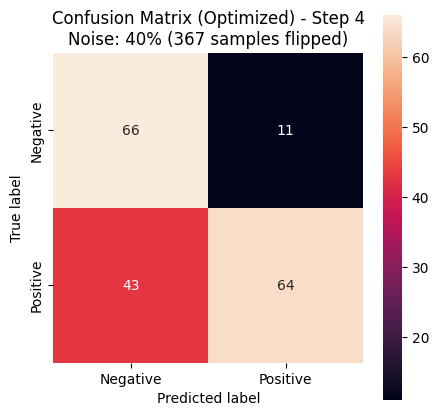

Feature Importances: [0.05351444 0.0452345  0.         0.07680235 0.         0.07186037
 0.         0.         0.         0.         0.24384294 0.02770257
 0.         0.         0.         0.         0.48104283 0.        ]
✅ Step 4 completed (Noise: 40%)


===== Training Decision Tree (Optimized) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.4891304347826087
Precision: 0.6140350877192983
Recall: 0.32710280373831774
F1-score: 0.4268292682926829
Step 5 - Decision Tree (Optimized) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.4891
  Accuracy Train:  0.5858
  Precision:       0.6140
  Recall:          0.3271
  F1-score:        0.4268
  Training time:   0.0008 sec


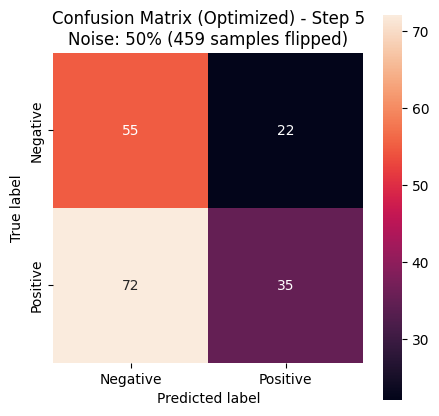

Feature Importances: [0.         0.19435399 0.         0.30048972 0.         0.0809645
 0.         0.18556502 0.         0.         0.         0.
 0.03769289 0.         0.         0.20093388 0.         0.        ]
✅ Step 5 completed (Noise: 50%)


===== Training Decision Tree (Optimized) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.21739130434782608
Precision: 0.12244897959183673
Recall: 0.056074766355140186
F1-score: 0.07692307692307693
Step 6 - Decision Tree (Optimized) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.2174
  Accuracy Train:  0.6213
  Precision:       0.1224
  Recall:          0.0561
  F1-score:        0.0769
  Training time:   0.0008 sec


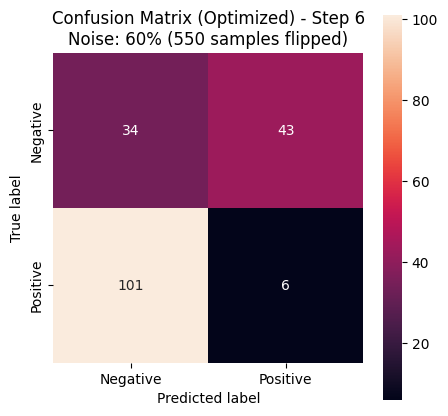

Feature Importances: [0.         0.         0.03510888 0.         0.07417049 0.
 0.         0.07719453 0.16109055 0.42210519 0.         0.
 0.         0.05327408 0.         0.         0.         0.17705628]
✅ Step 6 completed (Noise: 60%)


===== Training Decision Tree (Optimized) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.21739130434782608
Precision: 0.2318840579710145
Recall: 0.14953271028037382
F1-score: 0.18181818181818182
Step 7 - Decision Tree (Optimized) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.2174
  Accuracy Train:  0.6744
  Precision:       0.2319
  Recall:          0.1495
  F1-score:        0.1818
  Training time:   0.0008 sec


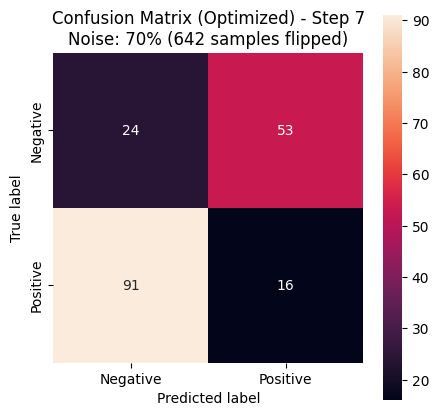

Feature Importances: [0.         0.         0.         0.         0.         0.
 0.06351362 0.         0.18857409 0.07952269 0.         0.
 0.10818661 0.03723097 0.         0.         0.         0.52297202]
✅ Step 7 completed (Noise: 70%)


===== Training Decision Tree (Optimized) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.20108695652173914
Precision: 0.22972972972972974
Recall: 0.1588785046728972
F1-score: 0.1878453038674033
Step 8 - Decision Tree (Optimized) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.2011
  Accuracy Train:  0.7330
  Precision:       0.2297
  Recall:          0.1589
  F1-score:        0.1878
  Training time:   0.0008 sec


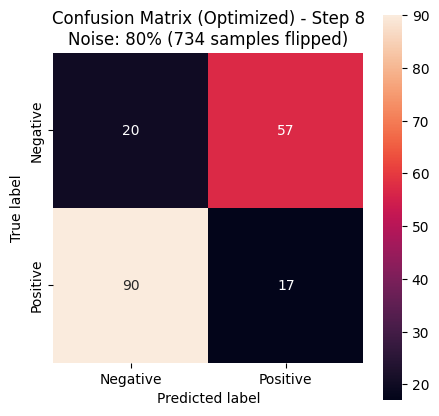

Feature Importances: [0.         0.0444191  0.         0.         0.         0.03463291
 0.07179493 0.         0.23085902 0.         0.         0.
 0.01745821 0.         0.         0.         0.         0.60083582]
✅ Step 8 completed (Noise: 80%)


===== Training Decision Tree (Optimized) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.20108695652173914
Precision: 0.22972972972972974
Recall: 0.1588785046728972
F1-score: 0.1878453038674033
Step 9 - Decision Tree (Optimized) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.2011
  Accuracy Train:  0.8079
  Precision:       0.2297
  Recall:          0.1589
  F1-score:        0.1878
  Training time:   0.0008 sec


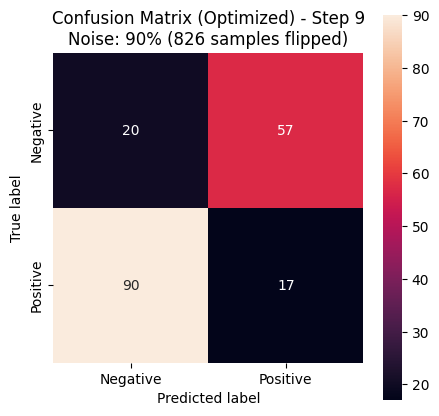

Feature Importances: [0.         0.06805608 0.         0.         0.         0.
 0.06180176 0.         0.20623758 0.         0.         0.
 0.         0.         0.         0.         0.         0.66390458]
✅ Step 9 completed (Noise: 90%)


===== Training Decision Tree (Optimized) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali decision tree optimized

Accuracy: 0.20108695652173914
Precision: 0.22972972972972974
Recall: 0.1588785046728972
F1-score: 0.1878453038674033
Step 10 - Decision Tree (Optimized) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.2011
  Accuracy Train:  0.8651
  Precision:       0.2297
  Recall:          0.1589
  F1-score:        0.1878
  Training time:   0.0010 sec


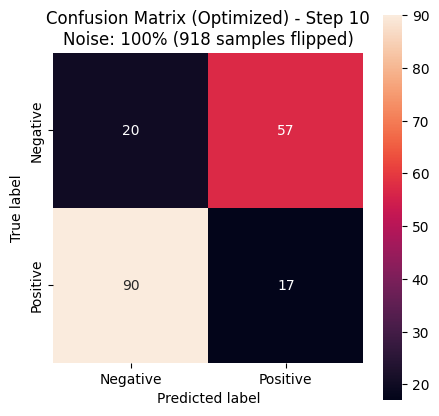

Feature Importances: [0.         0.05681672 0.         0.         0.         0.
 0.0420269  0.00643019 0.15558415 0.         0.         0.
 0.         0.         0.         0.         0.         0.73914205]
✅ Step 10 completed (Noise: 100%)



--- INIZIO TRAINING: SVM ---
DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training SVM (Naive) at Step 0 (Noise: 0%) =====
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7238095238095238
Recall: 0.7102803738317757
F1-score: 0.7169811320754716
Step 0 - SVM (Naive) - Noise: 0%
  Samples flipped: 0
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.6739
  Accuracy Train:  0.7044
  Precision:       0.7238
  Recall:          0.7103
  F1-score:        0.7170
  Training time:   0.0084 sec


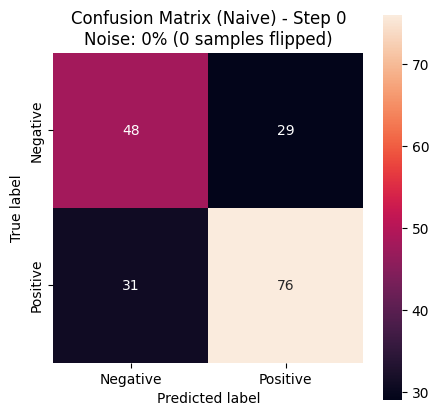

✅ Step 0 completed (Noise: 0%)


===== Training SVM (Naive) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.6847826086956522
Precision: 0.7378640776699029
Recall: 0.7102803738317757
F1-score: 0.7238095238095238
Step 1 - SVM (Naive) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.6848
  Accuracy Train:  0.6771
  Precision:       0.7379
  Recall:          0.7103
  F1-score:        0.7238
  Training time:   0.0089 sec


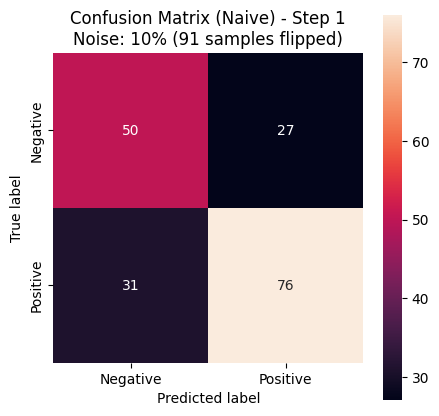

✅ Step 1 completed (Noise: 10%)


===== Training SVM (Naive) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.6793478260869565
Precision: 0.74
Recall: 0.6915887850467289
F1-score: 0.714975845410628
Step 2 - SVM (Naive) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.6793
  Accuracy Train:  0.6471
  Precision:       0.7400
  Recall:          0.6916
  F1-score:        0.7150
  Training time:   0.0081 sec


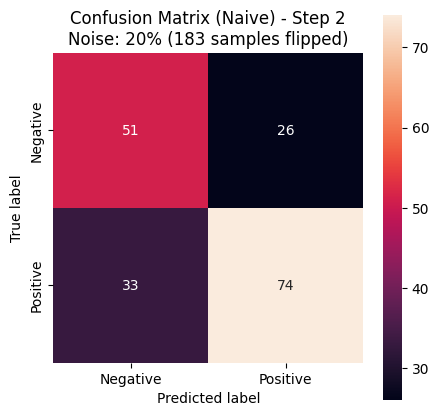

✅ Step 2 completed (Noise: 20%)


===== Training SVM (Naive) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.6195652173913043
Precision: 0.7466666666666667
Recall: 0.5233644859813084
F1-score: 0.6153846153846154
Step 3 - SVM (Naive) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.6196
  Accuracy Train:  0.5886
  Precision:       0.7467
  Recall:          0.5234
  F1-score:        0.6154
  Training time:   0.0086 sec


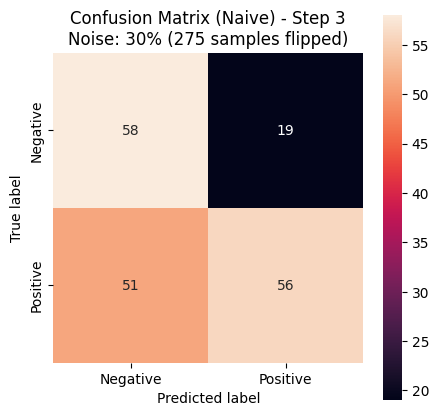

✅ Step 3 completed (Noise: 30%)


===== Training SVM (Naive) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.41847826086956524
Precision: 0.0
Recall: 0.0
F1-score: 0.0
Step 4 - SVM (Naive) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.4185
  Accuracy Train:  0.5368
  Precision:       0.0000
  Recall:          0.0000
  F1-score:        0.0000
  Training time:   0.0096 sec


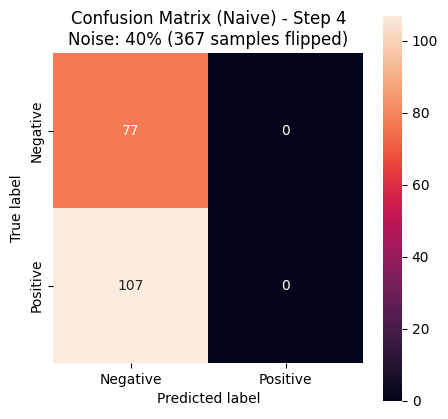

✅ Step 4 completed (Noise: 40%)


===== Training SVM (Naive) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.42934782608695654
Precision: 1.0
Recall: 0.018691588785046728
F1-score: 0.03669724770642202
Step 5 - SVM (Naive) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.4293
  Accuracy Train:  0.5259
  Precision:       1.0000
  Recall:          0.0187
  F1-score:        0.0367
  Training time:   0.0089 sec


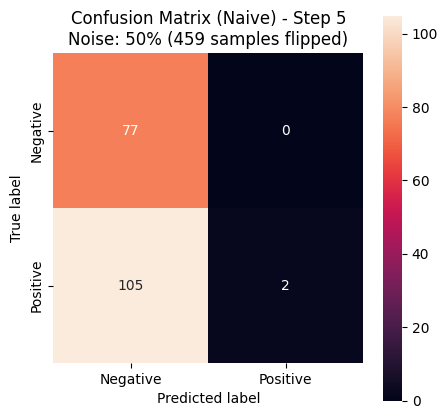

✅ Step 5 completed (Noise: 50%)


===== Training SVM (Naive) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.3858695652173913
Precision: 0.2857142857142857
Recall: 0.037383177570093455
F1-score: 0.06611570247933884
Step 6 - SVM (Naive) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.3859
  Accuracy Train:  0.5545
  Precision:       0.2857
  Recall:          0.0374
  F1-score:        0.0661
  Training time:   0.0230 sec


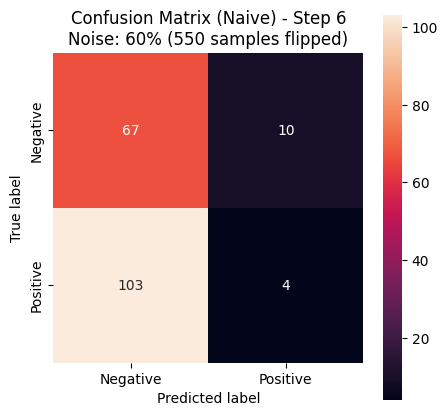

✅ Step 6 completed (Noise: 60%)


===== Training SVM (Naive) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.33695652173913043
Precision: 0.3333333333333333
Recall: 0.14018691588785046
F1-score: 0.19736842105263158
Step 7 - SVM (Naive) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.3370
  Accuracy Train:  0.6253
  Precision:       0.3333
  Recall:          0.1402
  F1-score:        0.1974
  Training time:   0.0086 sec


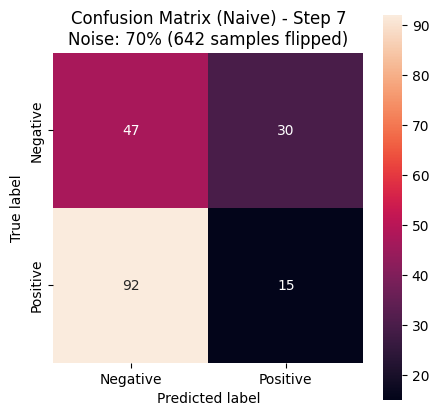

✅ Step 7 completed (Noise: 70%)


===== Training SVM (Naive) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.33152173913043476
Precision: 0.35714285714285715
Recall: 0.18691588785046728
F1-score: 0.24539877300613497
Step 8 - SVM (Naive) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.3315
  Accuracy Train:  0.6471
  Precision:       0.3571
  Recall:          0.1869
  F1-score:        0.2454
  Training time:   0.0082 sec


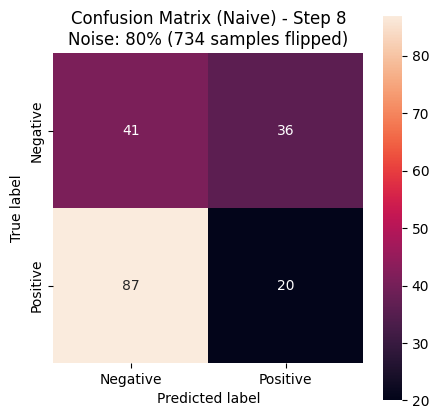

✅ Step 8 completed (Noise: 80%)


===== Training SVM (Naive) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.31521739130434784
Precision: 0.3492063492063492
Recall: 0.205607476635514
F1-score: 0.25882352941176473
Step 9 - SVM (Naive) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.3152
  Accuracy Train:  0.6853
  Precision:       0.3492
  Recall:          0.2056
  F1-score:        0.2588
  Training time:   0.0252 sec


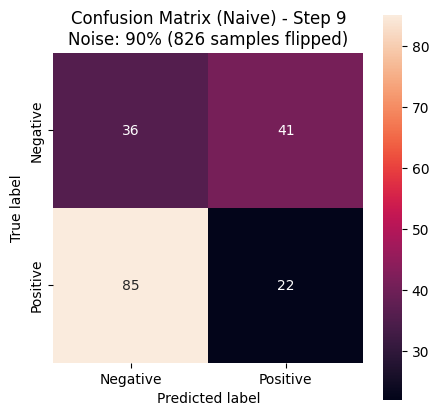

✅ Step 9 completed (Noise: 90%)


===== Training SVM (Naive) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali svm naive

Accuracy: 0.32608695652173914
Precision: 0.3924050632911392
Recall: 0.2897196261682243
F1-score: 0.3333333333333333
Step 10 - SVM (Naive) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.3261
  Accuracy Train:  0.7044
  Precision:       0.3924
  Recall:          0.2897
  F1-score:        0.3333
  Training time:   0.0088 sec


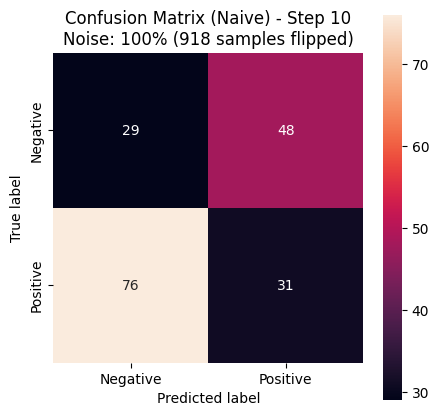

✅ Step 10 completed (Noise: 100%)

DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training SVM (Optimized) at Step 0 (Noise: 0%) =====
Misure di performance globali svm optimized

Accuracy: 0.6141304347826086
Precision: 0.652542372881356
Recall: 0.719626168224299
F1-score: 0.6844444444444444
Step 0 - SVM (Optimized) - Noise: 0%
  Samples flipped: 0
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.6141
  Accuracy Train:  1.0000
  Precision:       0.6525
  Recall:          0.7196
  F1-score:        0.6844
  Training time:   0.0137 sec


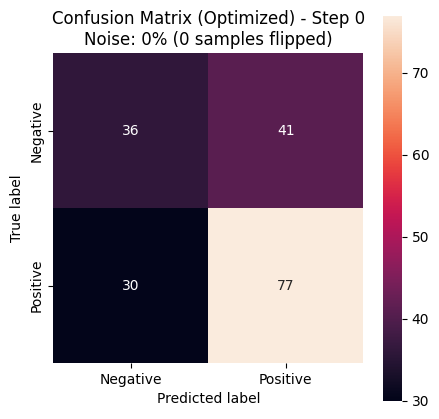

✅ Step 0 completed (Noise: 0%)


===== Training SVM (Optimized) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.625
Precision: 0.6610169491525424
Recall: 0.7289719626168224
F1-score: 0.6933333333333334
Step 1 - SVM (Optimized) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.6250
  Accuracy Train:  1.0000
  Precision:       0.6610
  Recall:          0.7290
  F1-score:        0.6933
  Training time:   0.0150 sec


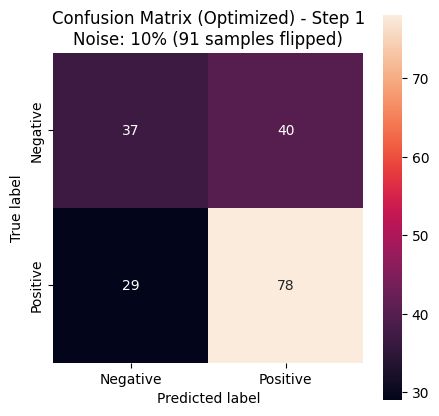

✅ Step 1 completed (Noise: 10%)


===== Training SVM (Optimized) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.6358695652173914
Precision: 0.6923076923076923
Recall: 0.6728971962616822
F1-score: 0.6824644549763034
Step 2 - SVM (Optimized) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.6359
  Accuracy Train:  1.0000
  Precision:       0.6923
  Recall:          0.6729
  F1-score:        0.6825
  Training time:   0.0268 sec


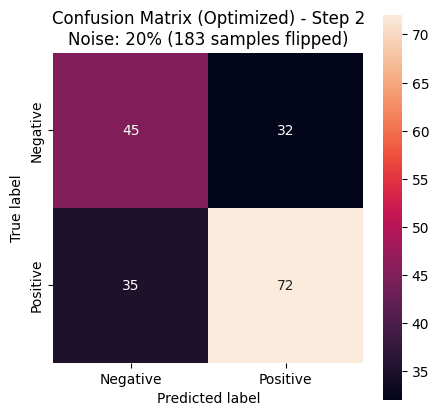

✅ Step 2 completed (Noise: 20%)


===== Training SVM (Optimized) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.6467391304347826
Precision: 0.71875
Recall: 0.6448598130841121
F1-score: 0.6798029556650246
Step 3 - SVM (Optimized) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.6467
  Accuracy Train:  1.0000
  Precision:       0.7188
  Recall:          0.6449
  F1-score:        0.6798
  Training time:   0.0195 sec


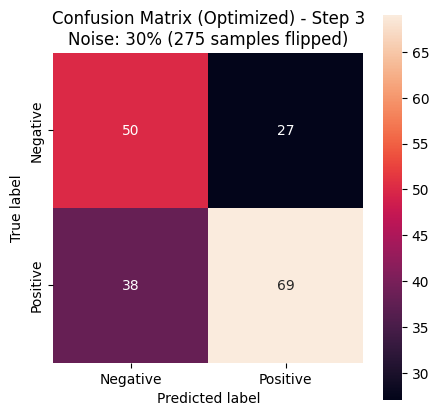

✅ Step 3 completed (Noise: 30%)


===== Training SVM (Optimized) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.5434782608695652
Precision: 0.6455696202531646
Recall: 0.4766355140186916
F1-score: 0.5483870967741935
Step 4 - SVM (Optimized) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.5435
  Accuracy Train:  1.0000
  Precision:       0.6456
  Recall:          0.4766
  F1-score:        0.5484
  Training time:   0.0134 sec


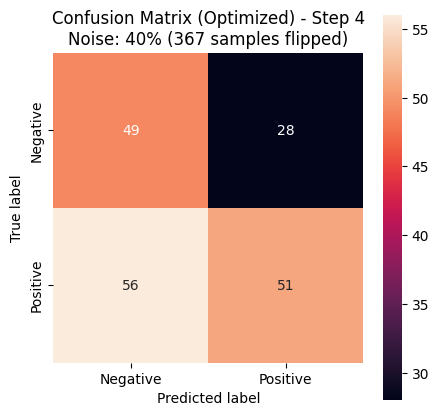

✅ Step 4 completed (Noise: 40%)


===== Training SVM (Optimized) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.5217391304347826
Precision: 0.611764705882353
Recall: 0.48598130841121495
F1-score: 0.5416666666666666
Step 5 - SVM (Optimized) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.5217
  Accuracy Train:  1.0000
  Precision:       0.6118
  Recall:          0.4860
  F1-score:        0.5417
  Training time:   0.0329 sec


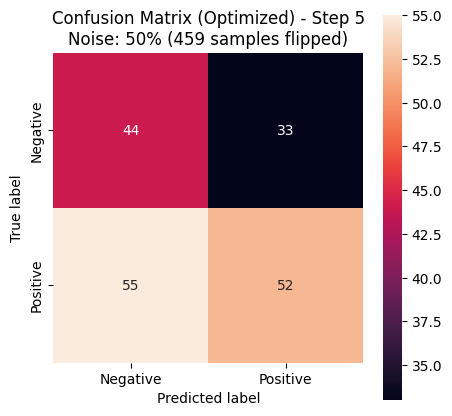

✅ Step 5 completed (Noise: 50%)


===== Training SVM (Optimized) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.44021739130434784
Precision: 0.5285714285714286
Recall: 0.34579439252336447
F1-score: 0.4180790960451977
Step 6 - SVM (Optimized) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.4402
  Accuracy Train:  1.0000
  Precision:       0.5286
  Recall:          0.3458
  F1-score:        0.4181
  Training time:   0.0196 sec


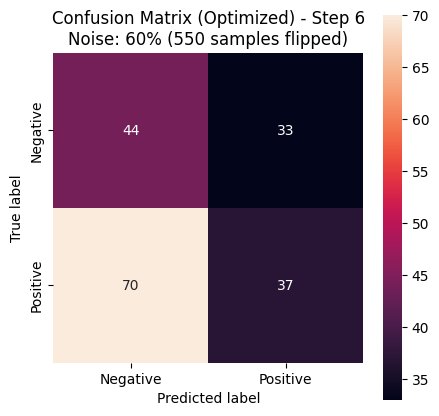

✅ Step 6 completed (Noise: 60%)


===== Training SVM (Optimized) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.41304347826086957
Precision: 0.4935064935064935
Recall: 0.35514018691588783
F1-score: 0.41304347826086957
Step 7 - SVM (Optimized) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.4130
  Accuracy Train:  1.0000
  Precision:       0.4935
  Recall:          0.3551
  F1-score:        0.4130
  Training time:   0.0163 sec


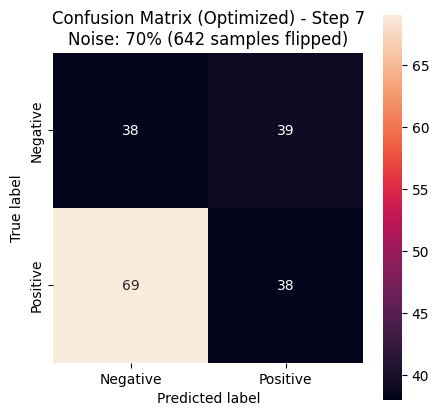

✅ Step 7 completed (Noise: 70%)


===== Training SVM (Optimized) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.43478260869565216
Precision: 0.5205479452054794
Recall: 0.35514018691588783
F1-score: 0.4222222222222222
Step 8 - SVM (Optimized) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.4348
  Accuracy Train:  1.0000
  Precision:       0.5205
  Recall:          0.3551
  F1-score:        0.4222
  Training time:   0.0182 sec


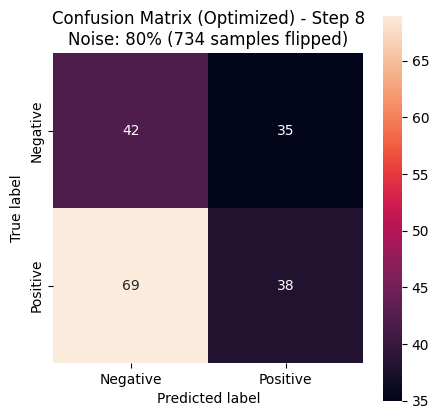

✅ Step 8 completed (Noise: 80%)


===== Training SVM (Optimized) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.3967391304347826
Precision: 0.4696969696969697
Recall: 0.2897196261682243
F1-score: 0.3583815028901734
Step 9 - SVM (Optimized) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.3967
  Accuracy Train:  1.0000
  Precision:       0.4697
  Recall:          0.2897
  F1-score:        0.3584
  Training time:   0.0127 sec


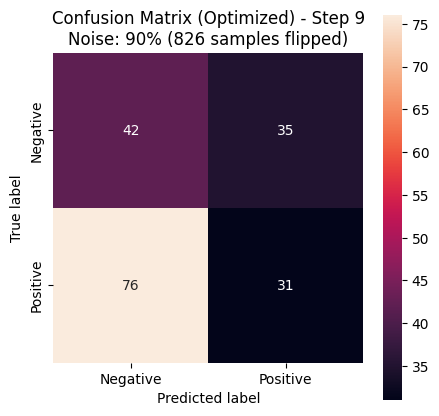

✅ Step 9 completed (Noise: 90%)


===== Training SVM (Optimized) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali svm optimized

Accuracy: 0.3858695652173913
Precision: 0.45454545454545453
Recall: 0.2803738317757009
F1-score: 0.3468208092485549
Step 10 - SVM (Optimized) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.3859
  Accuracy Train:  1.0000
  Precision:       0.4545
  Recall:          0.2804
  F1-score:        0.3468
  Training time:   0.0166 sec


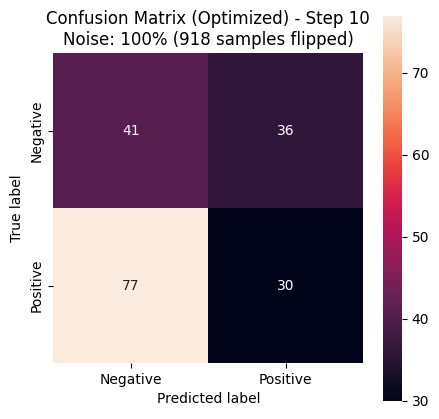

✅ Step 10 completed (Noise: 100%)



--- INIZIO TRAINING: NEURAL NETWORK ---
DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training Neural Network (Naive) at Step 0 (Noise: 0%) =====
Misure di performance globali neural network naive

Accuracy: 0.8315217391304348
Precision: 0.8166666666666667
Recall: 0.9158878504672897
F1-score: 0.8634361233480177
Step 0 - Neural Network (Naive) - Noise: 0%
  Samples flipped: 0
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.8315
  Accuracy Train:  0.8774
  Precision:       0.8167
  Recall:          0.9159
  F1-score:        0.8634
  Training time:   0.1115 sec


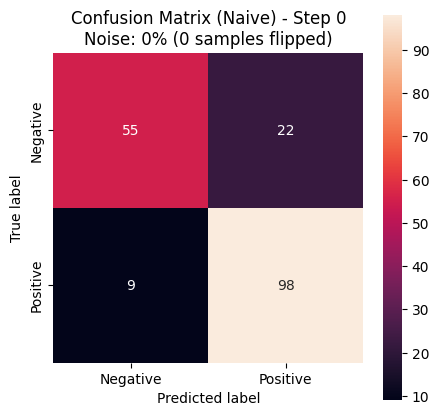

✅ Step 0 completed (Noise: 0%)


===== Training Neural Network (Naive) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.7608695652173914
Precision: 0.8705882352941177
Recall: 0.6915887850467289
F1-score: 0.7708333333333334
Step 1 - Neural Network (Naive) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.7609
  Accuracy Train:  0.7984
  Precision:       0.8706
  Recall:          0.6916
  F1-score:        0.7708
  Training time:   0.2064 sec


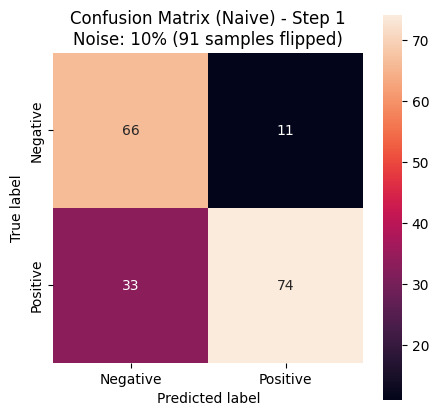

✅ Step 1 completed (Noise: 10%)


===== Training Neural Network (Naive) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.7608695652173914
Precision: 0.9090909090909091
Recall: 0.6542056074766355
F1-score: 0.7608695652173914
Step 2 - Neural Network (Naive) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.7609
  Accuracy Train:  0.7384
  Precision:       0.9091
  Recall:          0.6542
  F1-score:        0.7609
  Training time:   0.1361 sec


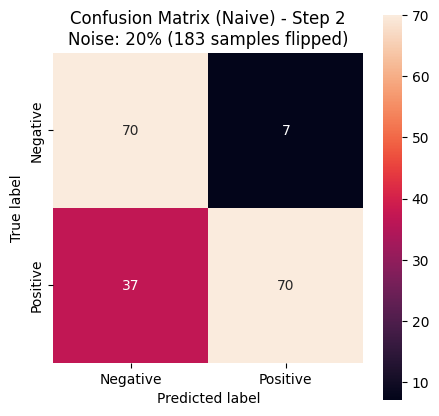

✅ Step 2 completed (Noise: 20%)


===== Training Neural Network (Naive) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.7608695652173914
Precision: 0.8058252427184466
Recall: 0.7757009345794392
F1-score: 0.7904761904761904
Step 3 - Neural Network (Naive) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.7609
  Accuracy Train:  0.6771
  Precision:       0.8058
  Recall:          0.7757
  F1-score:        0.7905
  Training time:   0.1352 sec


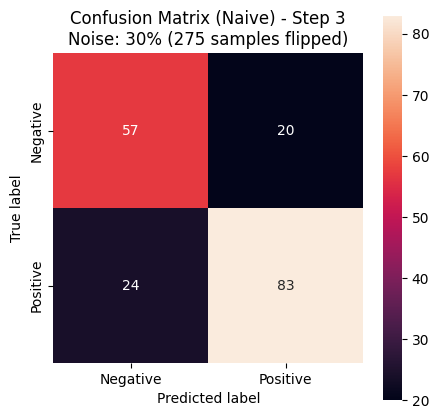

✅ Step 3 completed (Noise: 30%)


===== Training Neural Network (Naive) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.6467391304347826
Precision: 0.8088235294117647
Recall: 0.514018691588785
F1-score: 0.6285714285714286
Step 4 - Neural Network (Naive) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.6467
  Accuracy Train:  0.5940
  Precision:       0.8088
  Recall:          0.5140
  F1-score:        0.6286
  Training time:   0.1332 sec


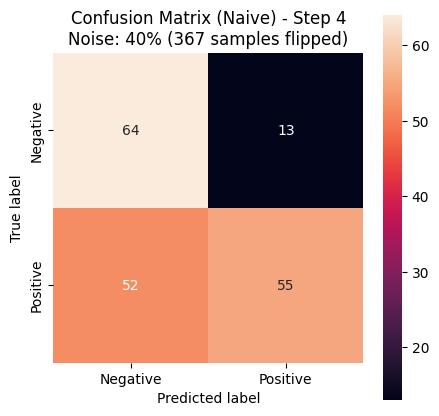

✅ Step 4 completed (Noise: 40%)


===== Training Neural Network (Naive) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.42391304347826086
Precision: 0.5111111111111111
Recall: 0.21495327102803738
F1-score: 0.3026315789473684
Step 5 - Neural Network (Naive) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.4239
  Accuracy Train:  0.5981
  Precision:       0.5111
  Recall:          0.2150
  F1-score:        0.3026
  Training time:   0.2376 sec


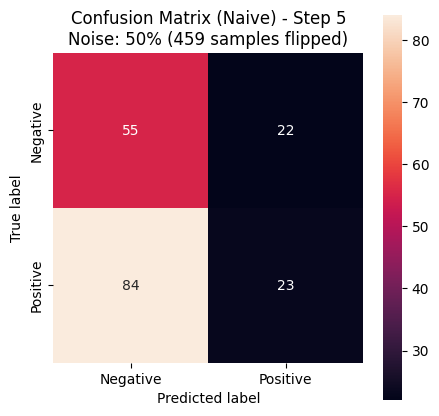

✅ Step 5 completed (Noise: 50%)


===== Training Neural Network (Naive) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.3641304347826087
Precision: 0.4583333333333333
Recall: 0.514018691588785
F1-score: 0.4845814977973568
Step 6 - Neural Network (Naive) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.3641
  Accuracy Train:  0.5886
  Precision:       0.4583
  Recall:          0.5140
  F1-score:        0.4846
  Training time:   0.0820 sec


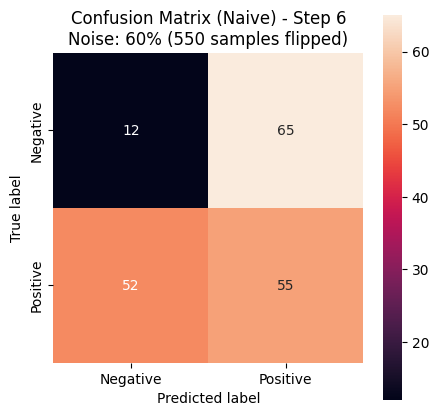

✅ Step 6 completed (Noise: 60%)


===== Training Neural Network (Naive) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.22282608695652173
Precision: 0.125
Recall: 0.056074766355140186
F1-score: 0.07741935483870968
Step 7 - Neural Network (Naive) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.2228
  Accuracy Train:  0.6676
  Precision:       0.1250
  Recall:          0.0561
  F1-score:        0.0774
  Training time:   0.1854 sec


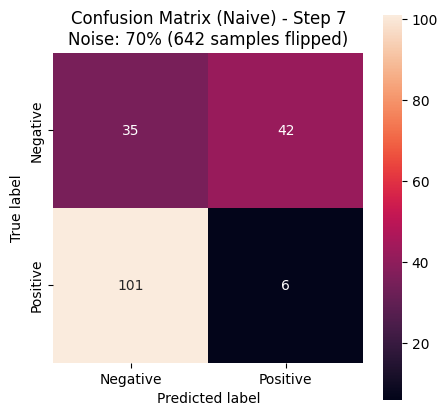

✅ Step 7 completed (Noise: 70%)


===== Training Neural Network (Naive) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.1956521739130435
Precision: 0.18461538461538463
Recall: 0.11214953271028037
F1-score: 0.13953488372093023
Step 8 - Neural Network (Naive) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.1957
  Accuracy Train:  0.7357
  Precision:       0.1846
  Recall:          0.1121
  F1-score:        0.1395
  Training time:   0.1144 sec


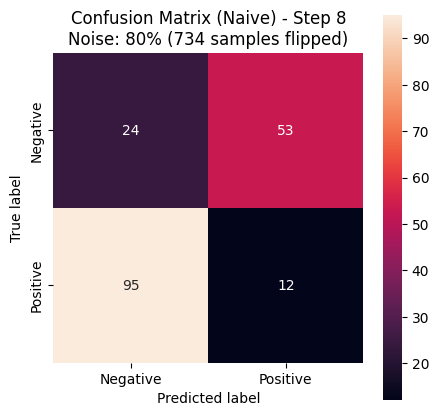

✅ Step 8 completed (Noise: 80%)


===== Training Neural Network (Naive) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.21739130434782608
Precision: 0.29213483146067415
Recall: 0.24299065420560748
F1-score: 0.2653061224489796
Step 9 - Neural Network (Naive) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.2174
  Accuracy Train:  0.7929
  Precision:       0.2921
  Recall:          0.2430
  F1-score:        0.2653
  Training time:   0.1522 sec


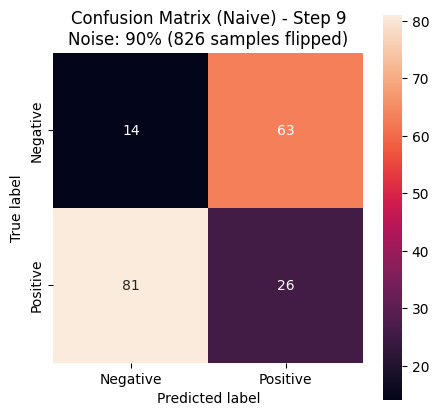

✅ Step 9 completed (Noise: 90%)


===== Training Neural Network (Naive) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali neural network naive

Accuracy: 0.17391304347826086
Precision: 0.17391304347826086
Recall: 0.11214953271028037
F1-score: 0.13636363636363635
Step 10 - Neural Network (Naive) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.1739
  Accuracy Train:  0.8760
  Precision:       0.1739
  Recall:          0.1121
  F1-score:        0.1364
  Training time:   0.1189 sec


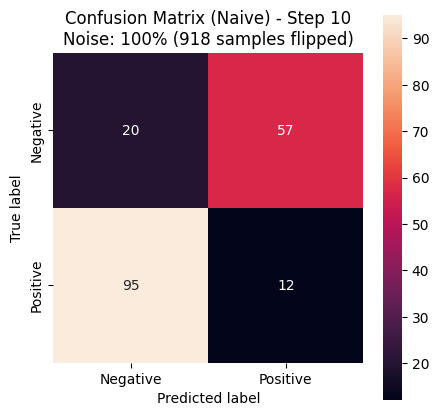

✅ Step 10 completed (Noise: 100%)

DataFrame originale con 918 righe.
Generando dataset con rumore progressivo e training modelli...


===== Training Neural Network (Optimized) at Step 0 (Noise: 0%) =====
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726
Step 0 - Neural Network (Optimized) - Noise: 0%
  Samples flipped: 0
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.8424
  Accuracy Train:  0.8747
  Precision:       0.8362
  Recall:          0.9065
  F1-score:        0.8700
  Training time:   0.1627 sec


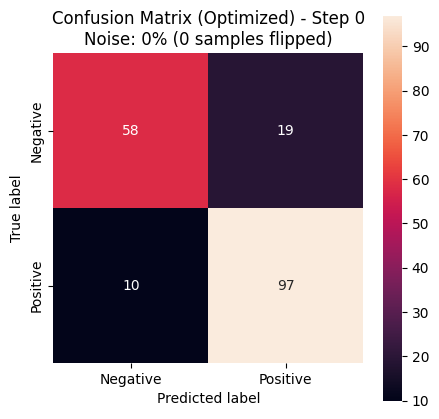

✅ Step 0 completed (Noise: 0%)


===== Training Neural Network (Optimized) at Step 1 (Noise: 10%) =====
Generato dataset con 10% di rumore (91 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.8152173913043478
Precision: 0.792
Recall: 0.9252336448598131
F1-score: 0.853448275862069
Step 1 - Neural Network (Optimized) - Noise: 10%
  Samples flipped: 91
  MI Numeriche:    0.0518
  MI Binarie:      0.0481
  Accuracy Test:   0.8152
  Accuracy Train:  0.7970
  Precision:       0.7920
  Recall:          0.9252
  F1-score:        0.8534
  Training time:   0.0874 sec


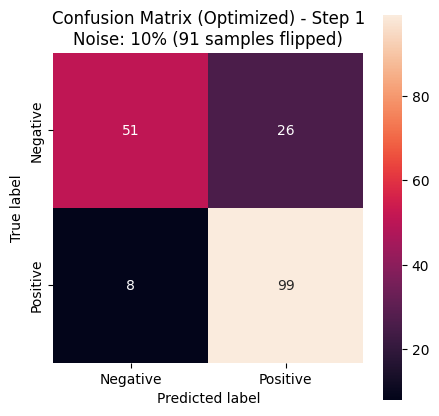

✅ Step 1 completed (Noise: 10%)


===== Training Neural Network (Optimized) at Step 2 (Noise: 20%) =====
Generato dataset con 20% di rumore (183 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.8043478260869565
Precision: 0.7669172932330827
Recall: 0.9532710280373832
F1-score: 0.85
Step 2 - Neural Network (Optimized) - Noise: 20%
  Samples flipped: 183
  MI Numeriche:    0.0299
  MI Binarie:      0.0321
  Accuracy Test:   0.8043
  Accuracy Train:  0.7098
  Precision:       0.7669
  Recall:          0.9533
  F1-score:        0.8500
  Training time:   0.1335 sec


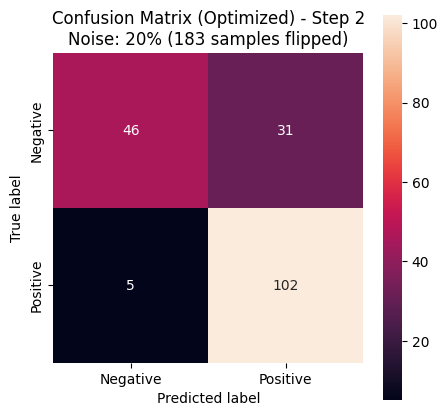

✅ Step 2 completed (Noise: 20%)


===== Training Neural Network (Optimized) at Step 3 (Noise: 30%) =====
Generato dataset con 30% di rumore (275 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.6086956521739131
Precision: 0.9487179487179487
Recall: 0.34579439252336447
F1-score: 0.5068493150684932
Step 3 - Neural Network (Optimized) - Noise: 30%
  Samples flipped: 275
  MI Numeriche:    0.0149
  MI Binarie:      0.0120
  Accuracy Test:   0.6087
  Accuracy Train:  0.6213
  Precision:       0.9487
  Recall:          0.3458
  F1-score:        0.5068
  Training time:   0.2232 sec


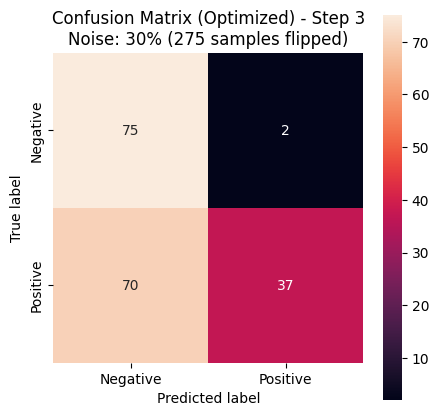

✅ Step 3 completed (Noise: 30%)


===== Training Neural Network (Optimized) at Step 4 (Noise: 40%) =====
Generato dataset con 40% di rumore (367 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.47282608695652173
Precision: 1.0
Recall: 0.09345794392523364
F1-score: 0.17094017094017094
Step 4 - Neural Network (Optimized) - Noise: 40%
  Samples flipped: 367
  MI Numeriche:    0.0183
  MI Binarie:      0.0085
  Accuracy Test:   0.4728
  Accuracy Train:  0.5804
  Precision:       1.0000
  Recall:          0.0935
  F1-score:        0.1709
  Training time:   0.0575 sec


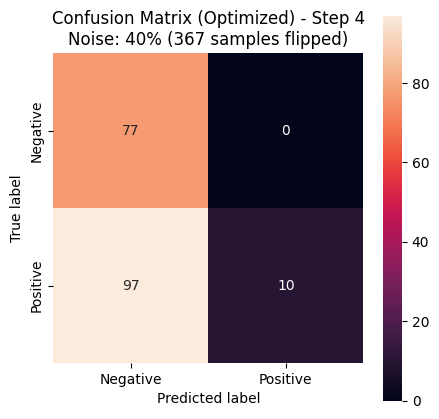

✅ Step 4 completed (Noise: 40%)


===== Training Neural Network (Optimized) at Step 5 (Noise: 50%) =====
Generato dataset con 50% di rumore (459 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.42934782608695654
Precision: 0.5833333333333334
Recall: 0.06542056074766354
F1-score: 0.11764705882352941
Step 5 - Neural Network (Optimized) - Noise: 50%
  Samples flipped: 459
  MI Numeriche:    0.0139
  MI Binarie:      0.0080
  Accuracy Test:   0.4293
  Accuracy Train:  0.5395
  Precision:       0.5833
  Recall:          0.0654
  F1-score:        0.1176
  Training time:   0.0644 sec


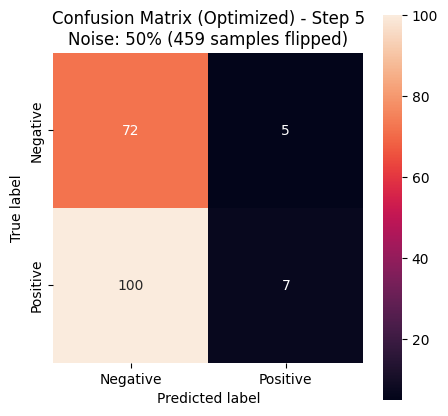

✅ Step 5 completed (Noise: 50%)


===== Training Neural Network (Optimized) at Step 6 (Noise: 60%) =====
Generato dataset con 60% di rumore (550 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.29347826086956524
Precision: 0.3114754098360656
Recall: 0.17757009345794392
F1-score: 0.2261904761904762
Step 6 - Neural Network (Optimized) - Noise: 60%
  Samples flipped: 550
  MI Numeriche:    0.0221
  MI Binarie:      0.0061
  Accuracy Test:   0.2935
  Accuracy Train:  0.6417
  Precision:       0.3115
  Recall:          0.1776
  F1-score:        0.2262
  Training time:   0.1313 sec


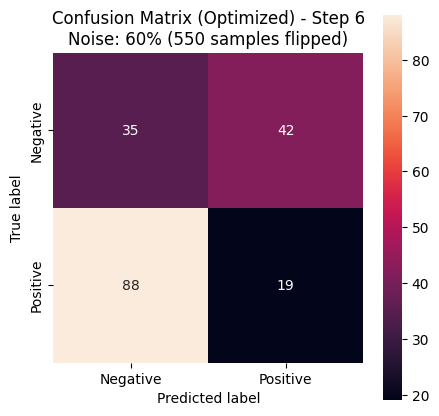

✅ Step 6 completed (Noise: 60%)


===== Training Neural Network (Optimized) at Step 7 (Noise: 70%) =====
Generato dataset con 70% di rumore (642 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.2391304347826087
Precision: 0.24615384615384617
Recall: 0.14953271028037382
F1-score: 0.18604651162790697
Step 7 - Neural Network (Optimized) - Noise: 70%
  Samples flipped: 642
  MI Numeriche:    0.0208
  MI Binarie:      0.0143
  Accuracy Test:   0.2391
  Accuracy Train:  0.6921
  Precision:       0.2462
  Recall:          0.1495
  F1-score:        0.1860
  Training time:   0.0973 sec


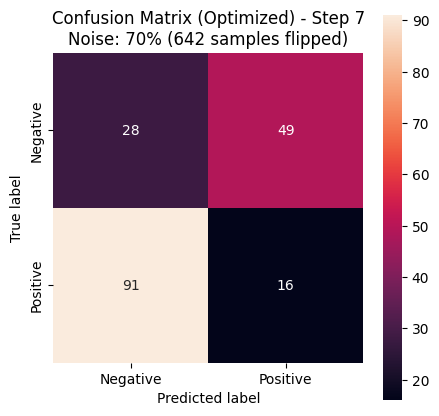

✅ Step 7 completed (Noise: 70%)


===== Training Neural Network (Optimized) at Step 8 (Noise: 80%) =====
Generato dataset con 80% di rumore (734 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.21195652173913043
Precision: 0.10416666666666667
Recall: 0.04672897196261682
F1-score: 0.06451612903225806
Step 8 - Neural Network (Optimized) - Noise: 80%
  Samples flipped: 734
  MI Numeriche:    0.0366
  MI Binarie:      0.0197
  Accuracy Test:   0.2120
  Accuracy Train:  0.7398
  Precision:       0.1042
  Recall:          0.0467
  F1-score:        0.0645
  Training time:   0.1228 sec


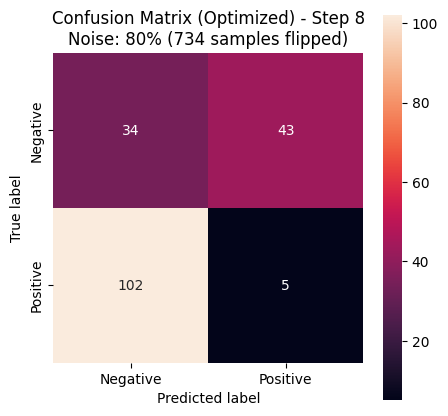

✅ Step 8 completed (Noise: 80%)


===== Training Neural Network (Optimized) at Step 9 (Noise: 90%) =====
Generato dataset con 90% di rumore (826 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.18478260869565216
Precision: 0.1791044776119403
Recall: 0.11214953271028037
F1-score: 0.13793103448275862
Step 9 - Neural Network (Optimized) - Noise: 90%
  Samples flipped: 826
  MI Numeriche:    0.0423
  MI Binarie:      0.0434
  Accuracy Test:   0.1848
  Accuracy Train:  0.8093
  Precision:       0.1791
  Recall:          0.1121
  F1-score:        0.1379
  Training time:   0.0874 sec


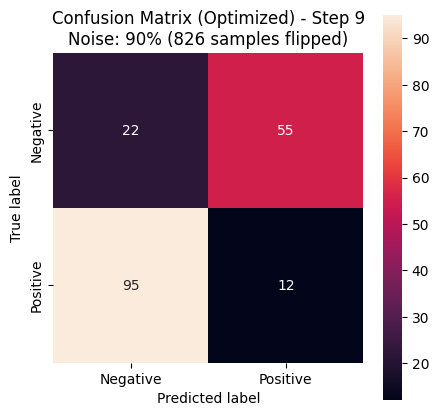

✅ Step 9 completed (Noise: 90%)


===== Training Neural Network (Optimized) at Step 10 (Noise: 100%) =====
Generato dataset con 100% di rumore (918 etichette invertite).
Misure di performance globali neural network optimized

Accuracy: 0.20108695652173914
Precision: 0.2727272727272727
Recall: 0.22429906542056074
F1-score: 0.24615384615384617
Step 10 - Neural Network (Optimized) - Noise: 100%
  Samples flipped: 918
  MI Numeriche:    0.0788
  MI Binarie:      0.0686
  Accuracy Test:   0.2011
  Accuracy Train:  0.8610
  Precision:       0.2727
  Recall:          0.2243
  F1-score:        0.2462
  Training time:   0.1728 sec


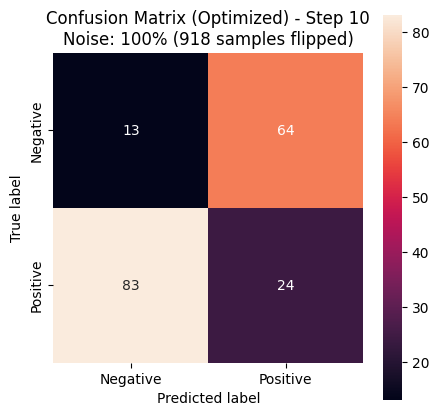

✅ Step 10 completed (Noise: 100%)



In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
import time

feature_importances = {}

confusion_matrix_values = {}


# Carica i modelli ottimizzati (se già salvati)
best_dt_params = joblib.load('best_decision_tree_model.pkl')
best_svm_params = joblib.load('best_svm_model.pkl')
best_nn_params = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn_params.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn_params.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

# Split del dataset originale per ottenere il test set pulito
X_original = df.drop('HeartDisease', axis=1)
y_original = df['HeartDisease']
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

noisy_datasets = add_progressive_noise(df, 'HeartDisease')


def add_progressive_noise_and_evaluate(
    df, target_column, X_test_clean, y_test_clean,
    model_class, model_params, model_name,
    approach_name, timing_collector, all_metrics_list,
    continuous_features, binary_features,
    mutua_informazione_feature=None,
    feature_importances=None
):
    """
    Aggiunge progressivamente rumore a una colonna target binaria (0/1) di un DataFrame,
    allena modelli per ogni step e calcola la mutual information.
    
    Args:
        df (pd.DataFrame): Il DataFrame di input.
        target_column (str): Il nome della colonna target binaria da modificare.
        X_test_clean: Features del test set pulito.
        y_test_clean: Target del test set pulito.
        model_class: Classe del modello da utilizzare.
        model_params: Parametri del modello.
        model_name (str): Nome del modello per identificazione.
        approach_name (str): Nome dell'approccio (es. 'noise_contamination').
        timing_collector (dict): Dizionario per collezionare i tempi di training.
        all_metrics_list (list): Lista per collezionare tutte le metriche.
        continuous_features (list): Lista nomi delle feature continue/numeriche.
        binary_features (list): Lista nomi delle feature binarie.
        mutua_informazione_feature (list, optional): Lista per collezionare i risultati MI.
        feature_importances (dict, optional): Dizionario per collezionare feature importances.
    
    Returns:
        dict: Un dizionario contenente i dataset con rumore progressivo.
    """
    # Controlla che la colonna target sia binaria (contenendo solo 0 e 1)
    if not all(df[target_column].isin([0, 1])):
        raise ValueError(f"La colonna '{target_column}' non è binaria (deve contenere solo 0 e 1).")
    
    noisy_datasets = {}
    n_samples = len(df)
    
    print(f"DataFrame originale con {n_samples} righe.")
    print("Generando dataset con rumore progressivo e training modelli...\n")

    cm_key = f"{model_name} - {approach_name}"
    if cm_key not in confusion_matrix_values:
        confusion_matrix_values[cm_key] = {}
    
    # Itera attraverso le percentuali di rumore da 0 a 100 con step di 10
    for step_idx, percentage in enumerate(range(0, 101, 10)):
        print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} (Noise: {percentage}%) =====")
        
        # Lavoriamo sempre su una copia pulita del df originale per evitare rumore cumulativo
        df_noisy = df.copy()
        
        # Se la percentuale è 0, non facciamo nulla e salviamo la copia originale
        if percentage == 0:
            noise_key = '0%_noise'
            noisy_datasets[noise_key] = df_noisy
            n_to_flip = 0
        else:
            # Calcola il numero di etichette da "flippare" (invertire)
            n_to_flip = int(np.floor(n_samples * (percentage / 100)))
            
            # Seleziona casualmente gli indici delle righe da modificare
            # Usiamo random_state per la riproducibilità degli esperimenti
            indices_to_flip = df.sample(n=n_to_flip, random_state=42).index
            
            # Inverti i valori nella colonna target per gli indici selezionati
            df_noisy.loc[indices_to_flip, target_column] = ~df_noisy.loc[indices_to_flip, target_column]
            
            # Salva il DataFrame rumoroso nel dizionario
            noise_key = f'{percentage}%_noise'
            noisy_datasets[noise_key] = df_noisy
            
            print(f"Generato dataset con {percentage}% di rumore ({n_to_flip} etichette invertite).")
        
        # Split del dataset contaminato
        X_contaminated = df_noisy.drop(target_column, axis=1)
        y_contaminated = df_noisy[target_column]
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Dati processati (niente imputazione perché dataset con rumore)
        X_train_processed = X_train
        X_test_processed = X_test_clean
        y_test = y_test_clean
        
        # Mutual Information sul training set
        mi = mutual_info_classif(X_train_processed, y_train, discrete_features='auto', random_state=42)
        mi_df = pd.DataFrame({
            "feature": X_train.columns,
            "mutual_info": mi
        })
        mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
        mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
        
        # Salva risultati mutual information
        if mutua_informazione_feature is not None:
            mutua_informazione_feature.append({
                "MI_numerical": mi_numerical,
                "MI_binary": mi_binary,
                "perc_noise": f"{percentage}%",
                "noise_samples": n_to_flip,
                "model": model_name,
                "approach": approach_name,
                "step": step_idx
            })
        
        # Training
        model = model_class(**model_params)
        start_time = time.time()
        model.fit(X_train_processed, y_train)
        end_time = time.time()
        training_time = end_time - start_time
        
        # Timing
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_noise_training_step_{step_idx}"
        timing_collector[timing_key] = training_time
        
        # Predizioni
        y_pred = model.predict(X_test_processed)
        y_pred_train = model.predict(X_train_processed)
        
        # Accuracy su training
        accuracy_train = accuracy_score(y_train, y_pred_train)
        
        # Calcolo metriche (assumendo che calculate_metrics sia già definita)
        metrics = calculate_metrics(y_test, y_pred, model_name, approach_name, step_idx)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['contamination_step'] = step_idx
        metrics['noise_percentage'] = percentage
        metrics['noise_samples'] = n_to_flip
        metrics['test_set_type'] = 'clean'
        
        # Aggiunta alle metriche globali
        all_metrics_list.append(metrics)
        
        # Stampa metriche step per step
        print(f"Step {step_idx} - {model_name} ({approach_name}) - Noise: {percentage}%")
        print(f"  Samples flipped: {n_to_flip}")
        print(f"  MI Numeriche:    {mi_numerical:.4f}")
        print(f"  MI Binarie:      {mi_binary:.4f}")
        print(f"  Accuracy Test:   {metrics['accuracy']:.4f}")
        print(f"  Accuracy Train:  {accuracy_train:.4f}")
        print(f"  Precision:       {metrics['precision']:.4f}")
        print(f"  Recall:          {metrics['recall']:.4f}")
        print(f"  F1-score:        {metrics['f1_score']:.4f}")
        print(f"  Training time:   {training_time:.4f} sec")
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        # Salva i valori nella struttura dati
        confusion_matrix_values[cm_key][step_idx] = {
            'TN': int(TN),  # True Negative
            'FP': int(FP),  # False Positive  
            'FN': int(FN),  # False Negative
            'TP': int(TP),  # True Positive
            'confusion_matrix': cm.tolist()  # Salva anche la matrice completa
        }
        plt.figure(figsize=(5,5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - Step {step_idx}\nNoise: {percentage}% ({n_to_flip} samples flipped)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Feature importances (solo Decision Tree)
        key = f"{model_name} - {approach_name}"
        if model_name == 'Decision Tree':
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = model.feature_importances_
            print(f"Feature Importances: {model.feature_importances_}")
        
        print(f"✅ Step {step_idx} completed (Noise: {percentage}%)\n")
    
    return noisy_datasets



# --- Decision Tree ---
print("\n\n--- INIZIO TRAINING: DECISION TREE ---")

# Decision Tree Naive
noisy_datasets_dt_naive = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=DecisionTreeClassifier, 
    model_params={},
    model_name='Decision Tree', 
    approach_name='Naive',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature,
    feature_importances=feature_importances
)

# Decision Tree Optimized
noisy_datasets_dt_opt = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=DecisionTreeClassifier, 
    model_params=best_dt_params,
    model_name='Decision Tree', 
    approach_name='Optimized',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature,
    feature_importances=feature_importances
)

# --- Support Vector Machine (SVM) ---
print("\n\n--- INIZIO TRAINING: SVM ---")

# SVM Naive
noisy_datasets_svm_naive = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=SVC, 
    model_params={},
    model_name='SVM', 
    approach_name='Naive',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature
)

# SVM Optimized
noisy_datasets_svm_opt = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=SVC, 
    model_params=best_svm_params,
    model_name='SVM', 
    approach_name='Optimized',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature
)

# --- Neural Network (NN) ---
print("\n\n--- INIZIO TRAINING: NEURAL NETWORK ---")

# Neural Network Naive
noisy_datasets_nn_naive = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=MLPClassifier, 
    model_params={},
    model_name='Neural Network', 
    approach_name='Naive',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature
)

# Neural Network Optimized
noisy_datasets_nn_opt = add_progressive_noise_and_evaluate(
    df=df, 
    target_column='HeartDisease',
    X_test_clean=X_test_clean, 
    y_test_clean=y_test_clean,
    model_class=MLPClassifier, 
    model_params=best_nn_params,
    model_name='Neural Network', 
    approach_name='Optimized',
    timing_collector=timing_collector_noisy, 
    all_metrics_list=all_metrics_noisy,
    continuous_features=continuous_features,
    binary_features=binary_features,
    mutua_informazione_feature=mutua_informazione_feature
)



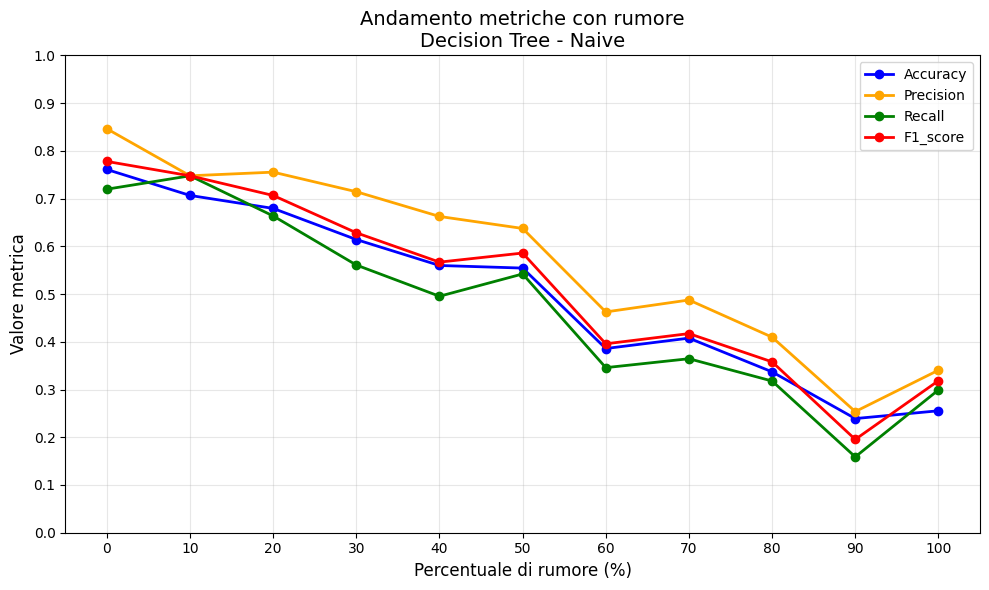

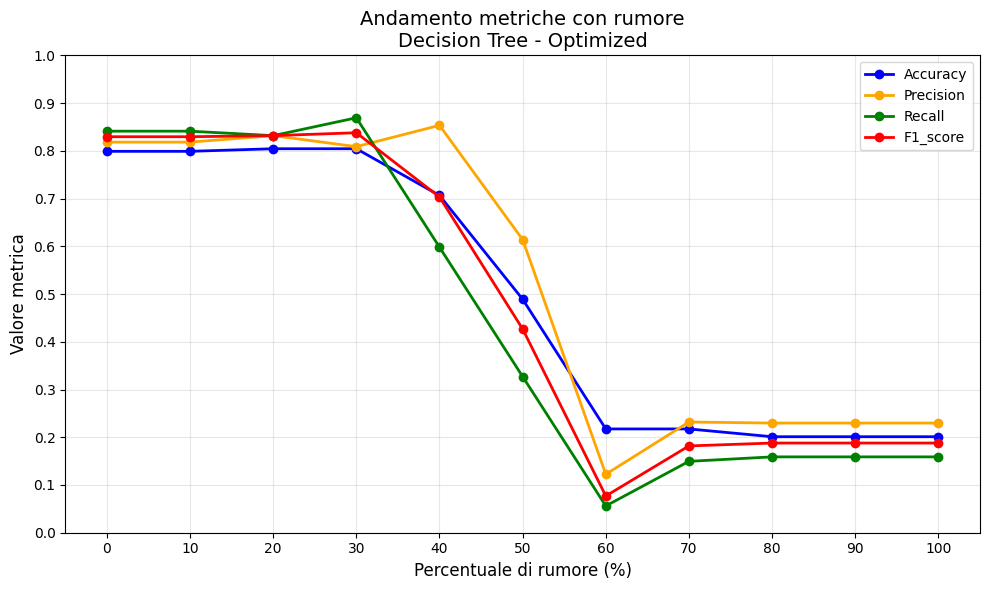

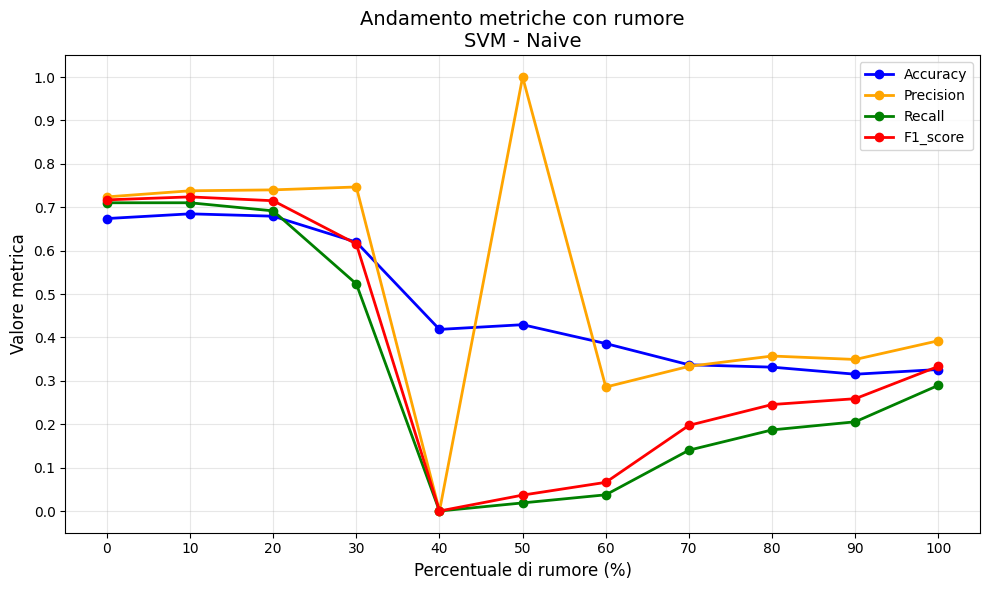

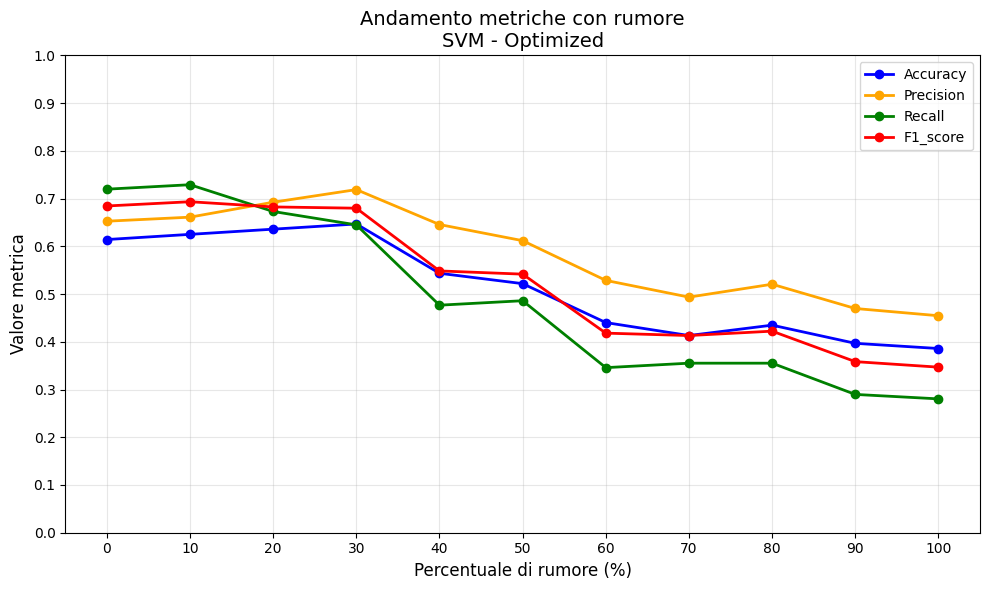

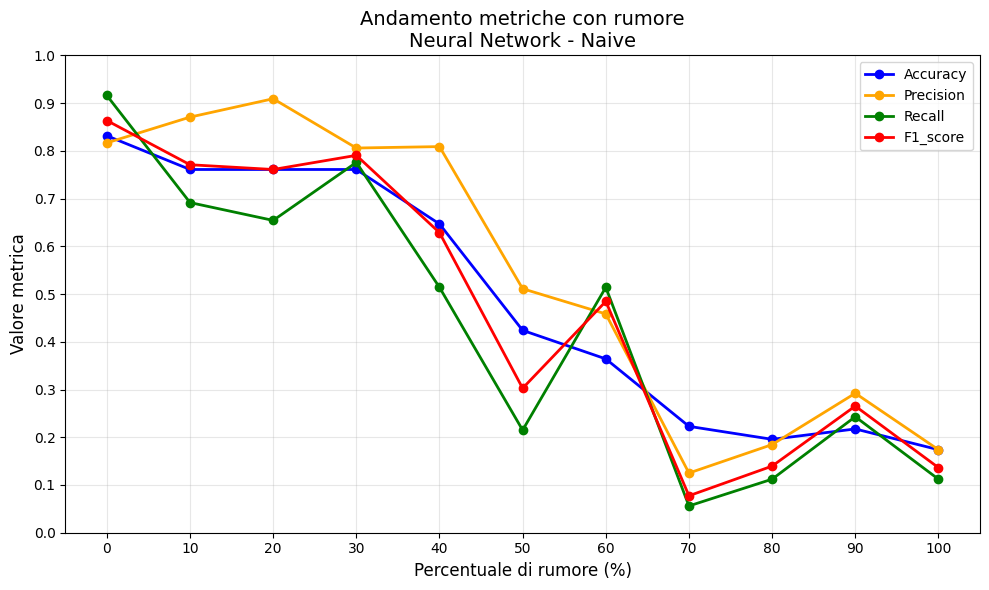

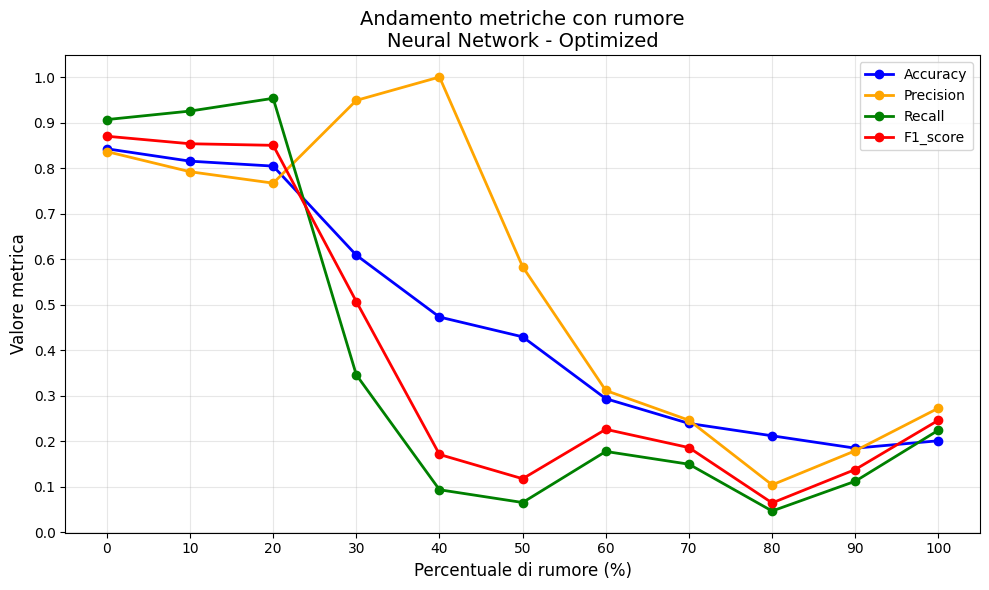

In [9]:
def plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, model_name, approach, figsize=(10, 6)):
    """
    Crea un grafico unico che mostra Accuracy, Precision, Recall e F1-score
    al crescere della percentuale di rumore per un dato modello e approccio,
    includendo il dataset pulito (0% rumore).
    
    Args:
        all_metrics_noisy: lista di metriche calcolate sui dataset rumorosi
        noisy_datasets: dizionario di DataFrame con valori rumorosi
        original_df: DataFrame originale pulito (senza rumore)
        model_name: nome del modello da plottare
        approach: 'Naive' o 'Optimized'
        figsize: dimensione del grafico
    """
    # Estrai le percentuali di rumore dai nomi dei dataset
    noise_percentages = []
    for key in noisy_datasets.keys():
        if key == '0%_noise':
            noise_percentages.append(0)
        else:
            # Estrai la percentuale dal nome (es: '10%_noise' -> 10)
            noise_percentages.append(int(key.split('%')[0]))
    
    # Ordina le percentuali
    noise_percentages.sort()
    
    # Filtriamo per modello e approccio
    filtered_metrics = []
    for metrics in all_metrics_noisy:
        if metrics["model"] == model_name and metrics["approach"] == approach:
            # Trova il dataset corrispondente al passo
            step = metrics['step']
            noise_percentage = metrics.get('noise_percentage', step)
            #noise_percentage = noise_percentages[step]
            metrics_copy = metrics.copy()
            metrics_copy['noise_percentage'] = noise_percentage
            filtered_metrics.append(metrics_copy)
    
    if not filtered_metrics:
        print(f"Nessun dato trovato per {model_name} ({approach})")
        return
    
    # Crea DataFrame
    metrics_df = pd.DataFrame(filtered_metrics)
    metrics_df = metrics_df.sort_values("noise_percentage")
    
    # Metriche da plottare
    metric_names = ['accuracy', 'precision', 'recall', 'f1_score']
    colors = ['blue', 'orange', 'green', 'red']
    
    plt.figure(figsize=figsize)
    
    for metric, color in zip(metric_names, colors):
        plt.plot(metrics_df["noise_percentage"], metrics_df[metric],
                 marker='o', linewidth=2, markersize=6, color=color, label=metric.capitalize())

    plt.xlabel("Percentuale di rumore (%)", fontsize=12)
    plt.ylabel("Valore metrica", fontsize=12)
    plt.title(f"Andamento metriche con rumore\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, 101, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

# Esempi di utilizzo
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Decision Tree', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Decision Tree', approach='Optimized')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'SVM', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'SVM', approach='Optimized')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Neural Network', approach='Naive')
plot_metrics_by_noise(all_metrics_noisy, noisy_datasets, 'Neural Network', approach='Optimized')

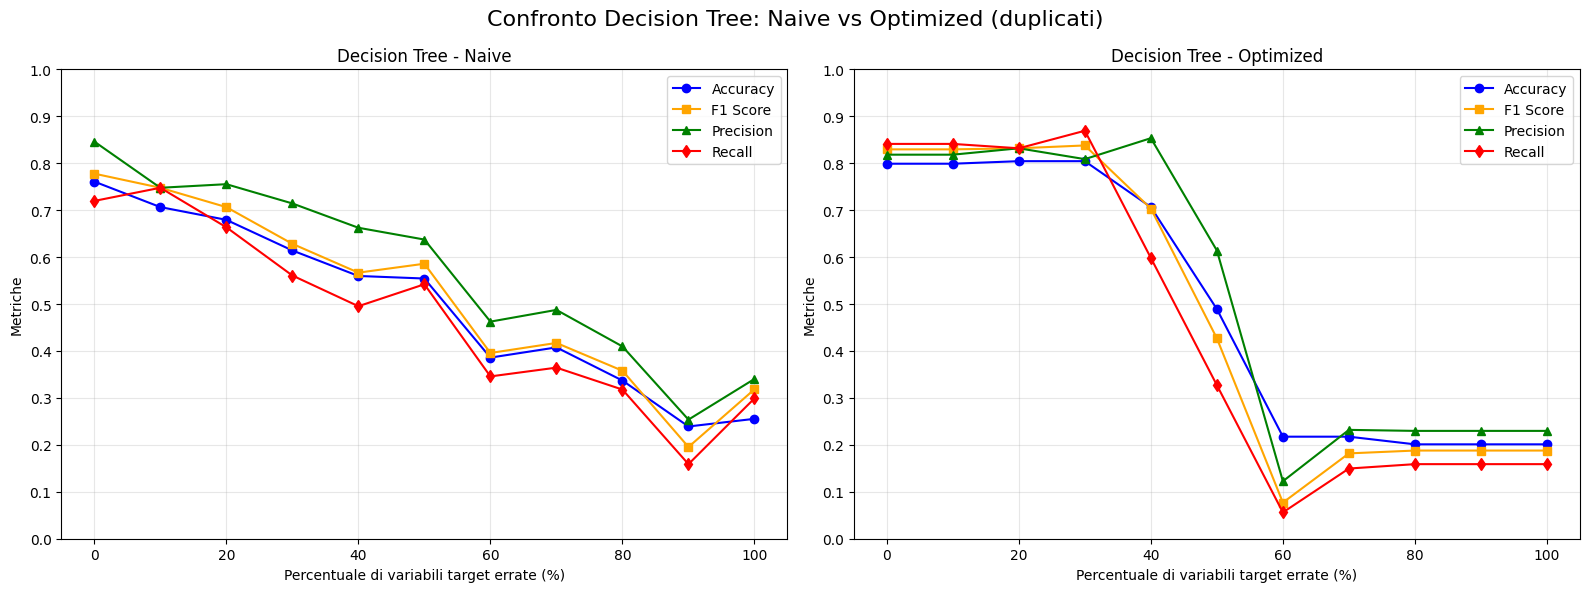

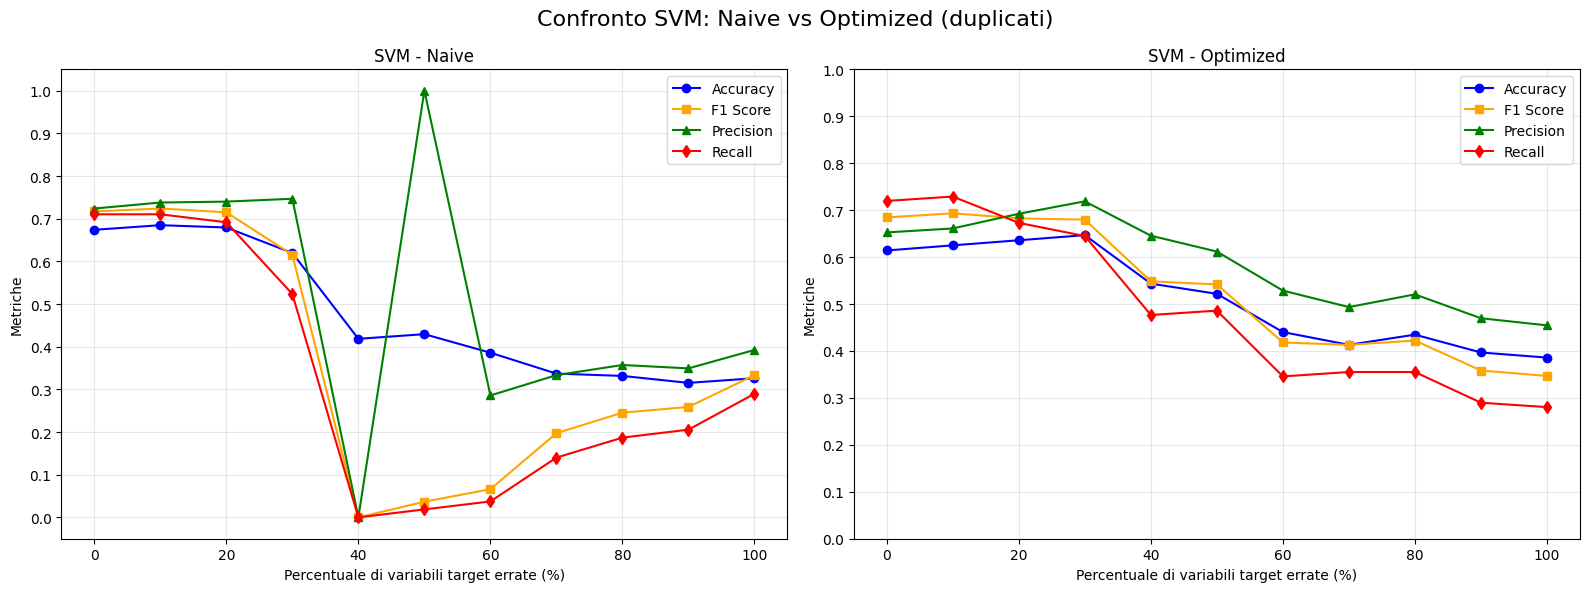

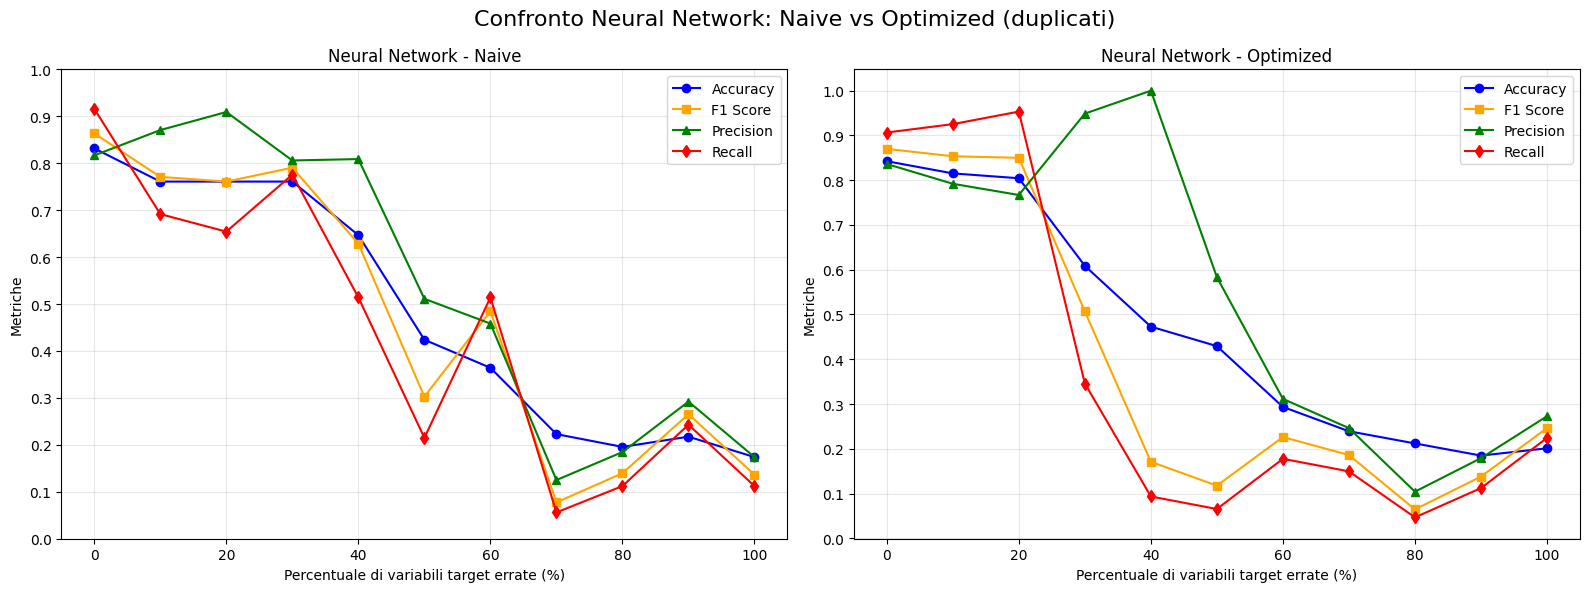

In [10]:
def plot_naive_vs_optimized_duplicates(model_name, original_df):
    """
    Confronta approccio Naive vs Optimized per un modello con dataset contenenti duplicati.
    
    Args:
        model_name: nome del modello da plottare
        duplicated_datasets: lista di DataFrame con duplicati
        original_df: dataset originale pulito
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        metrics_df = pd.DataFrame(all_metrics_noisy)
        
        # Filtriamo per modello e approccio
        filtered_df = metrics_df[
            (metrics_df["approach"] == approach) &
            (metrics_df["model"] == model_name)
        ].sort_values("noise_percentage")
        
        if filtered_df.empty:
            print(f"Nessun dato trovato per {model_name} ({approach})")
            continue
        
        # Aggiungiamo il caso pulito (0% duplicati) se non presente
        if not (filtered_df['noise_percentage'] == 0).any():
            clean_row = filtered_df.iloc[0].copy()
            clean_row['noise_percentage'] = 0
            filtered_df = pd.concat([pd.DataFrame([clean_row]), filtered_df], ignore_index=True)
        
        # Plot metriche
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["accuracy"], 
                     marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["f1_score"], 
                     marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["precision"], 
                     marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["noise_percentage"], filtered_df["recall"], 
                     marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di variabili target errate (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized (duplicati)", fontsize=16)
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized_duplicates('Decision Tree', df)
plot_naive_vs_optimized_duplicates('SVM', df)
plot_naive_vs_optimized_duplicates('Neural Network', df)


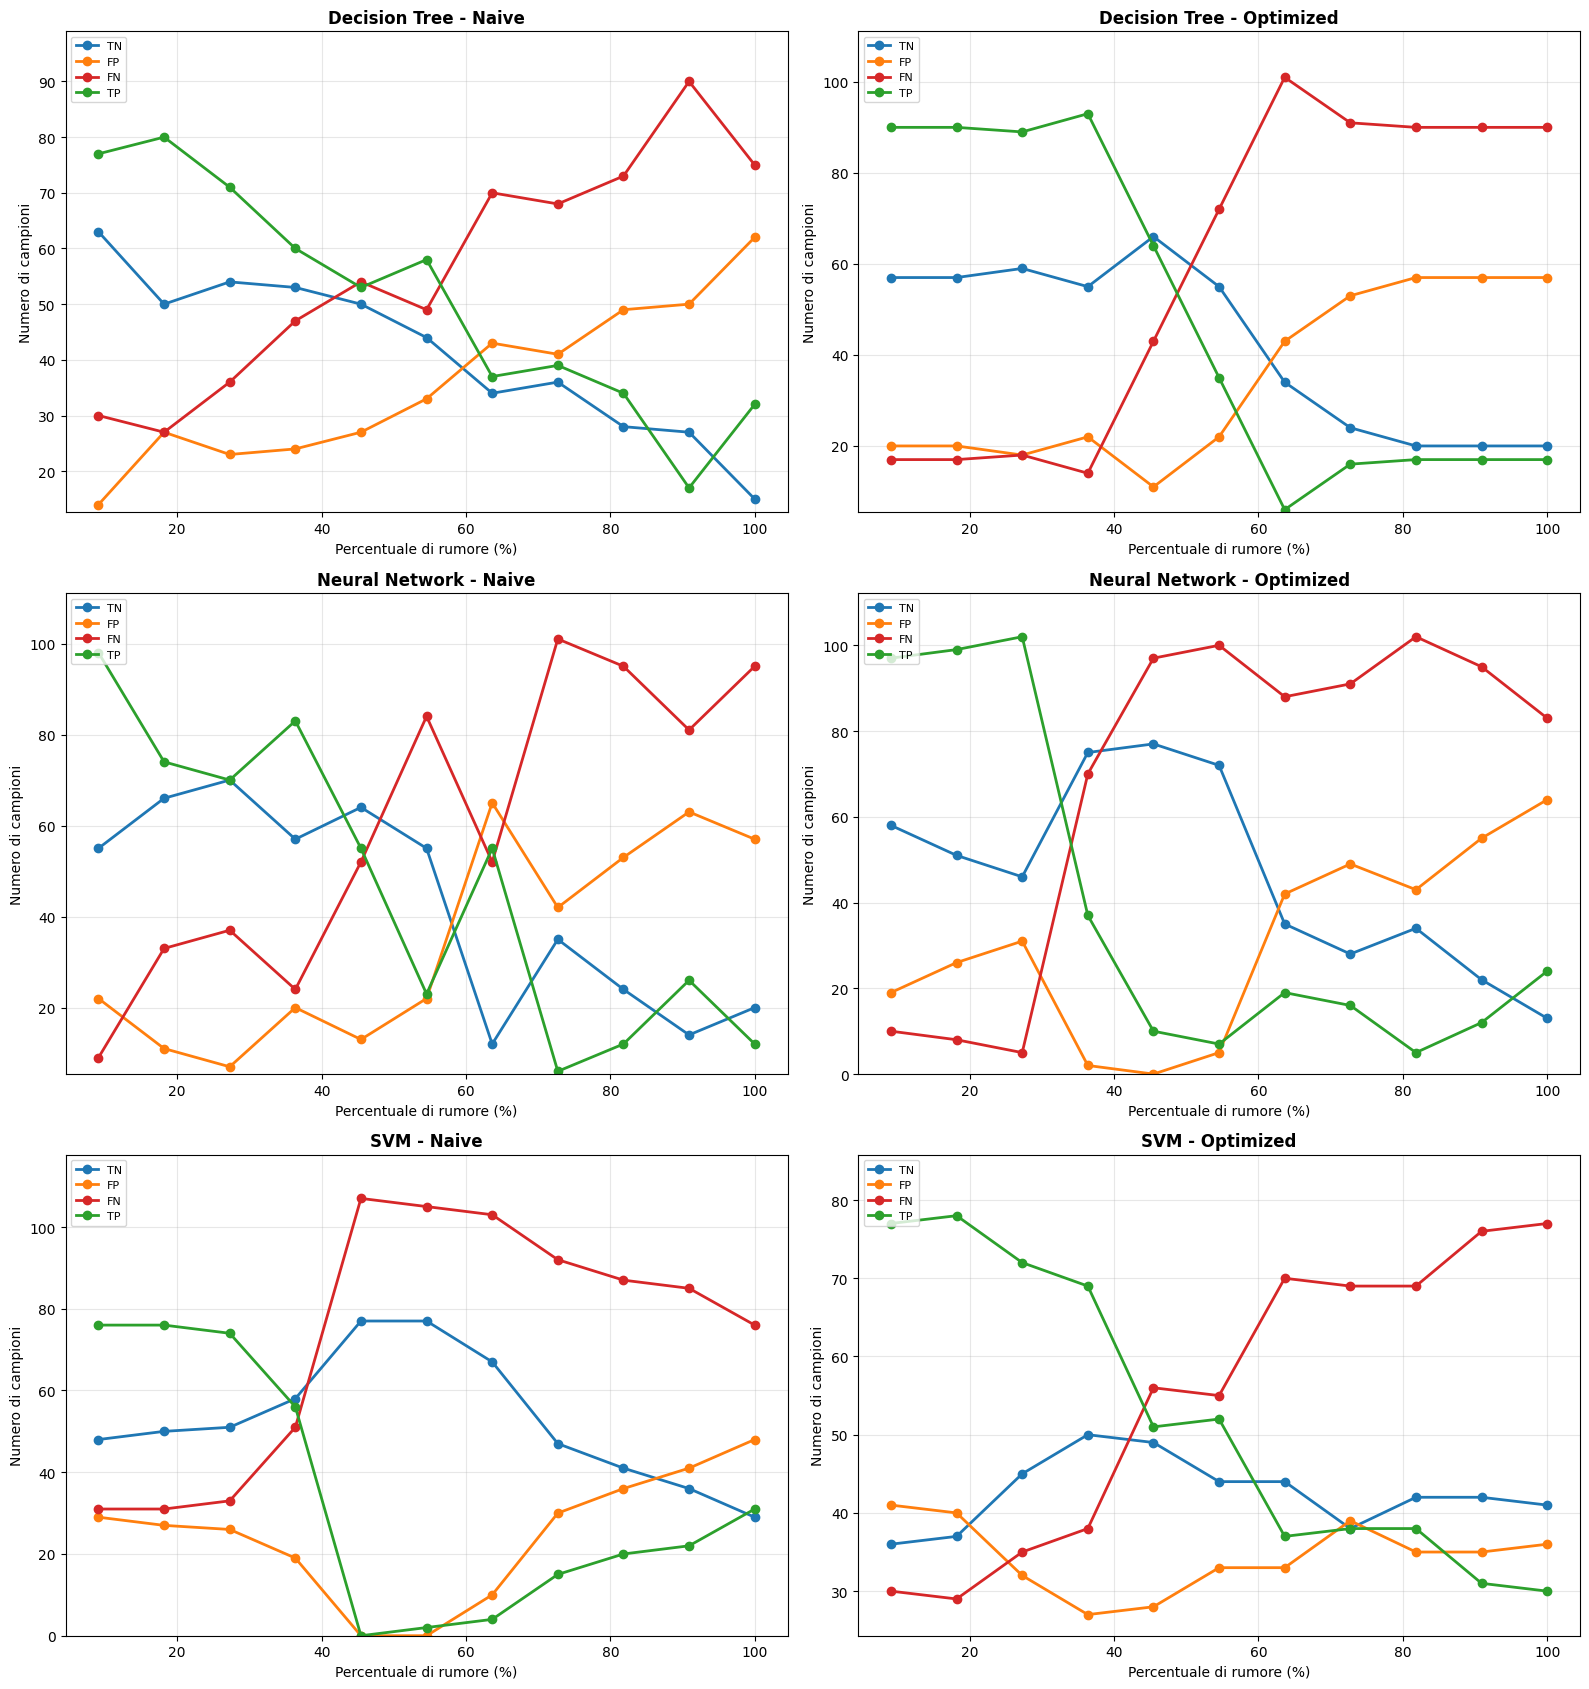

In [11]:
def plot_confusion_matrix_grid(confusion_matrix_values, noisy_datasets=None):
    """
    Crea una griglia di grafici 2 colonne x N righe (Naive | Optimized per modello)
    
    Parameters:
    -----------
    confusion_matrix_values : dict
        Dizionario con i valori delle confusion matrix
    contamination_history : list, optional
        Storia della contaminazione con step e actual_rate (default: usa step numerici)
    """
    
    # Estrai tutti i modelli unici (DT, SVM, NN)
    models = sorted(set(key.split(' - ')[0] for key in confusion_matrix_values.keys()))
    
    # Setup subplot: 2 colonne (Naive, Optimized), righe = numero modelli
    fig, axes = plt.subplots(len(models), 2, figsize=(16, 17))
    
    # Se c'è solo un modello, axes diventa 1D → forzo 2D
    if len(models) == 1:
        axes = [axes]
    
    colors = {
        'TN': '#1f77b4',  # blu
        'FP': '#ff7f0e',  # arancione  
        'FN': '#d62728',  # rosso
        'TP': '#2ca02c'   # verde
    }
    
    for model_idx, model in enumerate(models):
        for col_idx, approach in enumerate(["Naive", "Optimized"]):
            ax = axes[model_idx][col_idx]
            
            # Trova la chiave corretta (es: "Decision Tree - Naive")
            model_key = f"{model} - {approach}"
            if model_key not in confusion_matrix_values:
                continue
            
            # Estrai gli step
            steps = sorted(confusion_matrix_values[model_key].keys())
            
            nsteps = len(noisy_datasets) if noisy_datasets is not None else (max(steps) + 1)
            x_values = [((s+1) / nsteps) * 100 for s in steps]
            x_label = "Percentuale di rumore (%)"
            
            # Estrai valori TN, FP, FN, TP
            metrics_data = {
                'TN': [confusion_matrix_values[model_key][step]['TN'] for step in steps],
                'FP': [confusion_matrix_values[model_key][step]['FP'] for step in steps],
                'FN': [confusion_matrix_values[model_key][step]['FN'] for step in steps],
                'TP': [confusion_matrix_values[model_key][step]['TP'] for step in steps]
            }
            
            # Plot linee
            for metric in ['TN', 'FP', 'FN', 'TP']:
                ax.plot(x_values, metrics_data[metric], 
                        color=colors[metric], 
                        marker='o',
                        linestyle='-',
                        label=metric,
                        linewidth=2,
                        markersize=6)
            
            # Personalizza subplot
            ax.set_title(f"{model} - {approach}", fontsize=12, fontweight='bold')
            ax.set_xlabel(x_label, fontsize=10)
            ax.set_ylabel("Numero di campioni", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8, loc='upper left')
            
            # Limiti Y dinamici
            all_values = [v for metric in metrics_data.values() for v in metric]
            ax.set_ylim(min(all_values) * 0.9, max(all_values) * 1.1)
    
    plt.tight_layout()
    plt.show()

# Usa la funzione corretta
plot_confusion_matrix_grid(confusion_matrix_values, noisy_datasets)

=== ANALISI DELL'IMPATTO DELLE FEATURE ===



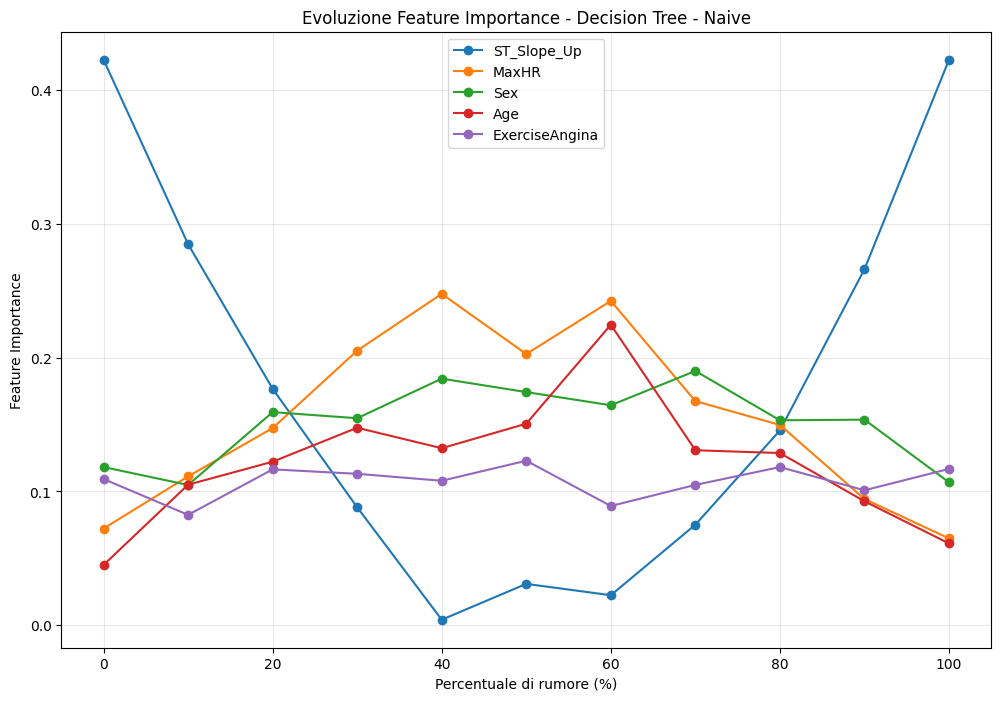


Decision Tree - Naive:
Media importanza feature continue: 0.0850
Media importanza feature binarie: 0.0442


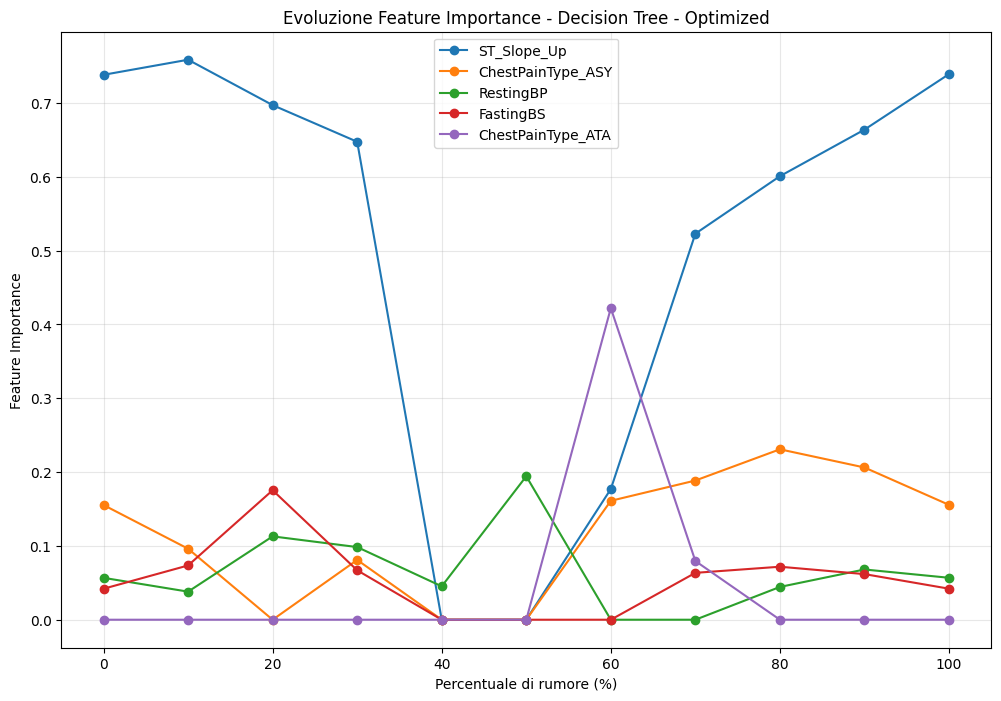


Decision Tree - Optimized:
Media importanza feature continue: 0.0238
Media importanza feature binarie: 0.0678


In [14]:
# %%
# ANALISI AGGIUNTIVE PER IL PROGETTO MISSING VALUES

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

'''
# %%
# 4. ANALISI ROC E CALIBRAZIONE
def roc_calibration_analysis(all_metrics_outliers, degraded_datasets, X_test_clean, y_test_clean):
    """
    Analisi delle curve ROC e della calibrazione dei modelli
    """
    print("=== ANALISI ROC E CALIBRAZIONE ===\n")
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.calibration import CalibratedClassifierCV
    
    # Testa su alcuni step rappresentativi
    test_steps = [0.1, 0.3, 0.5]
    models_config = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    fig, axes = plt.subplots(len(test_steps), 3, figsize=(18, 6*len(test_steps)))
    if len(test_steps) == 1:
        axes = axes.reshape(1, -1)
    
    roc_results = []
    
    for step_idx, perc in enumerate(test_steps):
        if perc not in degraded_datasets:
            continue
            
        df_degraded = degraded_datasets[perc]
        X_contaminated = df_degraded.drop('HeartDisease', axis=1)
        y_contaminated = df_degraded['HeartDisease']
        
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=42
        )
        
        imputer = SimpleImputer(strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test_clean)
        
        for model_idx, (model_name, model) in enumerate(models_config.items()):
            model.fit(X_train_imp, y_train)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_imp)[:, 1]
            else:
                y_proba = model.decision_function(X_test_imp)
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test_clean, y_proba)
            auc_score = roc_auc_score(y_test_clean, y_proba)
            
            axes[step_idx, model_idx].plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
            axes[step_idx, model_idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[step_idx, model_idx].set_xlabel('False Positive Rate')
            axes[step_idx, model_idx].set_ylabel('True Positive Rate')
            axes[step_idx, model_idx].set_title(f'{model_name} - {int(perc*100)}% Missing')
            axes[step_idx, model_idx].legend()
            axes[step_idx, model_idx].grid(True, alpha=0.3)
            
            roc_results.append({
                'model': model_name,
                'missing_perc': perc,
                'auc_score': auc_score
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(roc_results)
    '''

# %%
# 5. ANALISI DELL'IMPATTO SPECIFICO DELLE FEATURE
def feature_impact_analysis(feature_importances, continuous_features, binary_features):
    """
    Analizza come l'importanza delle feature cambia con l'aumento dei missing values
    """

    # Rimuovi la target dalle liste se presente
    continuous_features = [f for f in continuous_features if f != 'HeartDisease']
    binary_features = [f for f in binary_features if f != 'HeartDisease']

    print("=== ANALISI DELL'IMPATTO DELLE FEATURE ===\n")
    
    if not feature_importances:
        print("Nessuna feature importance disponibile")
        return
    
    # Solo per Decision Tree che ha feature_importances
    for model_approach, step_importances in feature_importances.items():
        if 'Decision Tree' not in model_approach:
            continue
            
        # Crea DataFrame delle importanze per step
        importance_data = []
        for step, importances in step_importances.items():
            # Verifica che importances sia un array/lista valida
            if importances is not None and len(importances) > 0:
                for feat_idx, importance in enumerate(importances):
                    importance_data.append({
                        'step': step,
                        'feature_idx': feat_idx,
                        'importance': importance
                    })
        
        if not importance_data:
            continue
            
        importance_df = pd.DataFrame(importance_data)
        
        # Visualizza l'evoluzione delle top 5 feature più importanti
        plt.figure(figsize=(12, 8))
        
        # Trova le top feature basate sull'importanza media
        avg_importance = importance_df.groupby('feature_idx')['importance'].mean().sort_values(ascending=False)
        top_features = avg_importance.head(5).index
        
        for feat_idx in top_features:
            feat_data = importance_df[importance_df['feature_idx'] == feat_idx].sort_values('step')
            # Ottieni il nome della feature corrispondente all'indice
            if feat_idx < len(continuous_features):
                feat_name = continuous_features[feat_idx]
            elif feat_idx < len(continuous_features) + len(binary_features):
                feat_name = binary_features[feat_idx - len(continuous_features)]
            else:
                feat_name = f"Feature {feat_idx}"
            plt.plot(feat_data['step']*10, feat_data['importance'], 
                    marker='o', label=feat_name)
        
        plt.xlabel('Percentuale di rumore (%)')
        plt.ylabel('Feature Importance')
        plt.title(f'Evoluzione Feature Importance - {model_approach}')
        plt.legend(loc ='upper center')
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Analisi separata per feature continue vs binarie (se hai i nomi delle feature)
        print(f"\n{model_approach}:")
        
        # Verifica che gli indici esistano prima di accedervi
        continuous_indices = [i for i in range(len(continuous_features)) if i in avg_importance.index]
        binary_start = len(continuous_features)
        binary_end = len(continuous_features) + len(binary_features)
        binary_indices = [i for i in range(binary_start, binary_end) if i in avg_importance.index]
        
        if continuous_indices:
            print(f"Media importanza feature continue: {avg_importance[continuous_indices].mean():.4f}")
        else:
            print("Nessuna feature continua trovata negli indici")
            
        if binary_indices:
            print(f"Media importanza feature binarie: {avg_importance[binary_indices].mean():.4f}")
        else:
            print("Nessuna feature binaria trovata negli indici")

# Esegui l'analisi comprehensive:
comprehensive_results = feature_impact_analysis(feature_importances, continuous_features, binary_features)

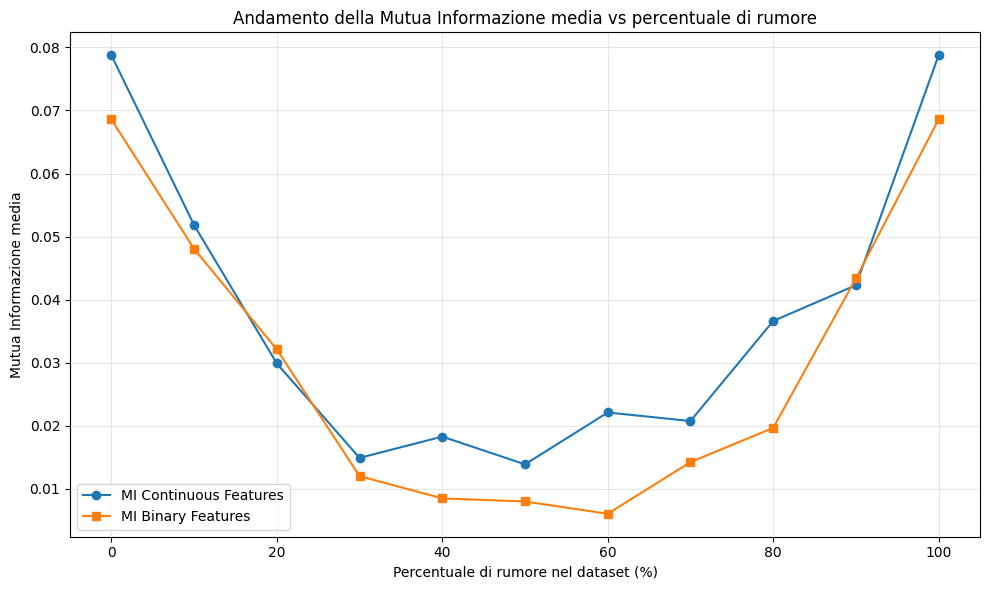

Primi righe del DataFrame dei risultati:
   MI_numerical  MI_binary perc_noise  noise_samples          model approach  \
0      0.078756   0.068576         0%              0  Decision Tree    Naive   
1      0.051823   0.048061        10%             91  Decision Tree    Naive   
2      0.029890   0.032120        20%            183  Decision Tree    Naive   
3      0.014920   0.012034        30%            275  Decision Tree    Naive   
4      0.018297   0.008500        40%            367  Decision Tree    Naive   

   step  noise_percentage  
0     0               0.0  
1     1              10.0  
2     2              20.0  
3     3              30.0  
4     4              40.0  

Colonne disponibili: ['MI_numerical', 'MI_binary', 'perc_noise', 'noise_samples', 'model', 'approach', 'step', 'noise_percentage']

Numero totale di records: 66

Statistiche MI per step:
    noise_percentage  MI_numerical  MI_binary
0                0.0      0.078756   0.068576
1               10.0      0.05

In [16]:
# Trasformiamo mutua_informazione_feature in DataFrame
df_results = pd.DataFrame(mutua_informazione_feature)

# Convertiamo la percentuale da stringa a float
# Nota: il campo si chiama "perc_noise" non "noise_percentage"
df_results["noise_percentage"] = df_results["perc_noise"].str.rstrip('%').astype(float)

# Raggruppiamo per percentuale di rumore e calcoliamo la media
df_grouped = df_results.groupby("noise_percentage")[["MI_numerical", "MI_binary"]].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(df_grouped["noise_percentage"], df_grouped["MI_numerical"], marker='o', label="MI Continuous Features")
plt.plot(df_grouped["noise_percentage"], df_grouped["MI_binary"], marker='s', label="MI Binary Features")
plt.xlabel("Percentuale di rumore nel dataset (%)")
plt.ylabel("Mutua Informazione media")
plt.title("Andamento della Mutua Informazione media vs percentuale di rumore")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Opzionale: stampa del DataFrame per debug
print("Primi righe del DataFrame dei risultati:")
print(df_results.head())
print(f"\nColonne disponibili: {df_results.columns.tolist()}")
print(f"\nNumero totale di records: {len(df_results)}")

# Opzionale: visualizza statistiche per step
print("\nStatistiche MI per step:")
print(df_grouped)